Importing packages. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from get_regression_coefs_general import get_regression_coefs 
from tabulate import tabulate
import matplotlib.ticker as mticker

## A (i) & (ii) — Trend Calculations of Real GDP and Real GDP Per Capita

To analyse the trend of real GDP and real GDP per capita, we consider the following models:

### 1) Additive Linear Model:
$$
y_t = \beta_0 + \beta_1 t + u_t
$$

### 2) Additive Quadratic Model:
$$
y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + u_t
$$

### 3) Exponential Growth Model:
$$
\log y_t = \beta_0 + \beta_1 t + u_t
$$

### 4) Exponential Quadratic Model:
$$
\log y_t = \beta_0 + \beta_1 t + \beta_2 t^2 + u_t
$$

where:
- $ y_t $ represents real GDP or real GDP per capita in year $ t $,
- $ \beta_0, \beta_1, \beta_2 $ are model coefficients,
- $ u_t $ is the error term.


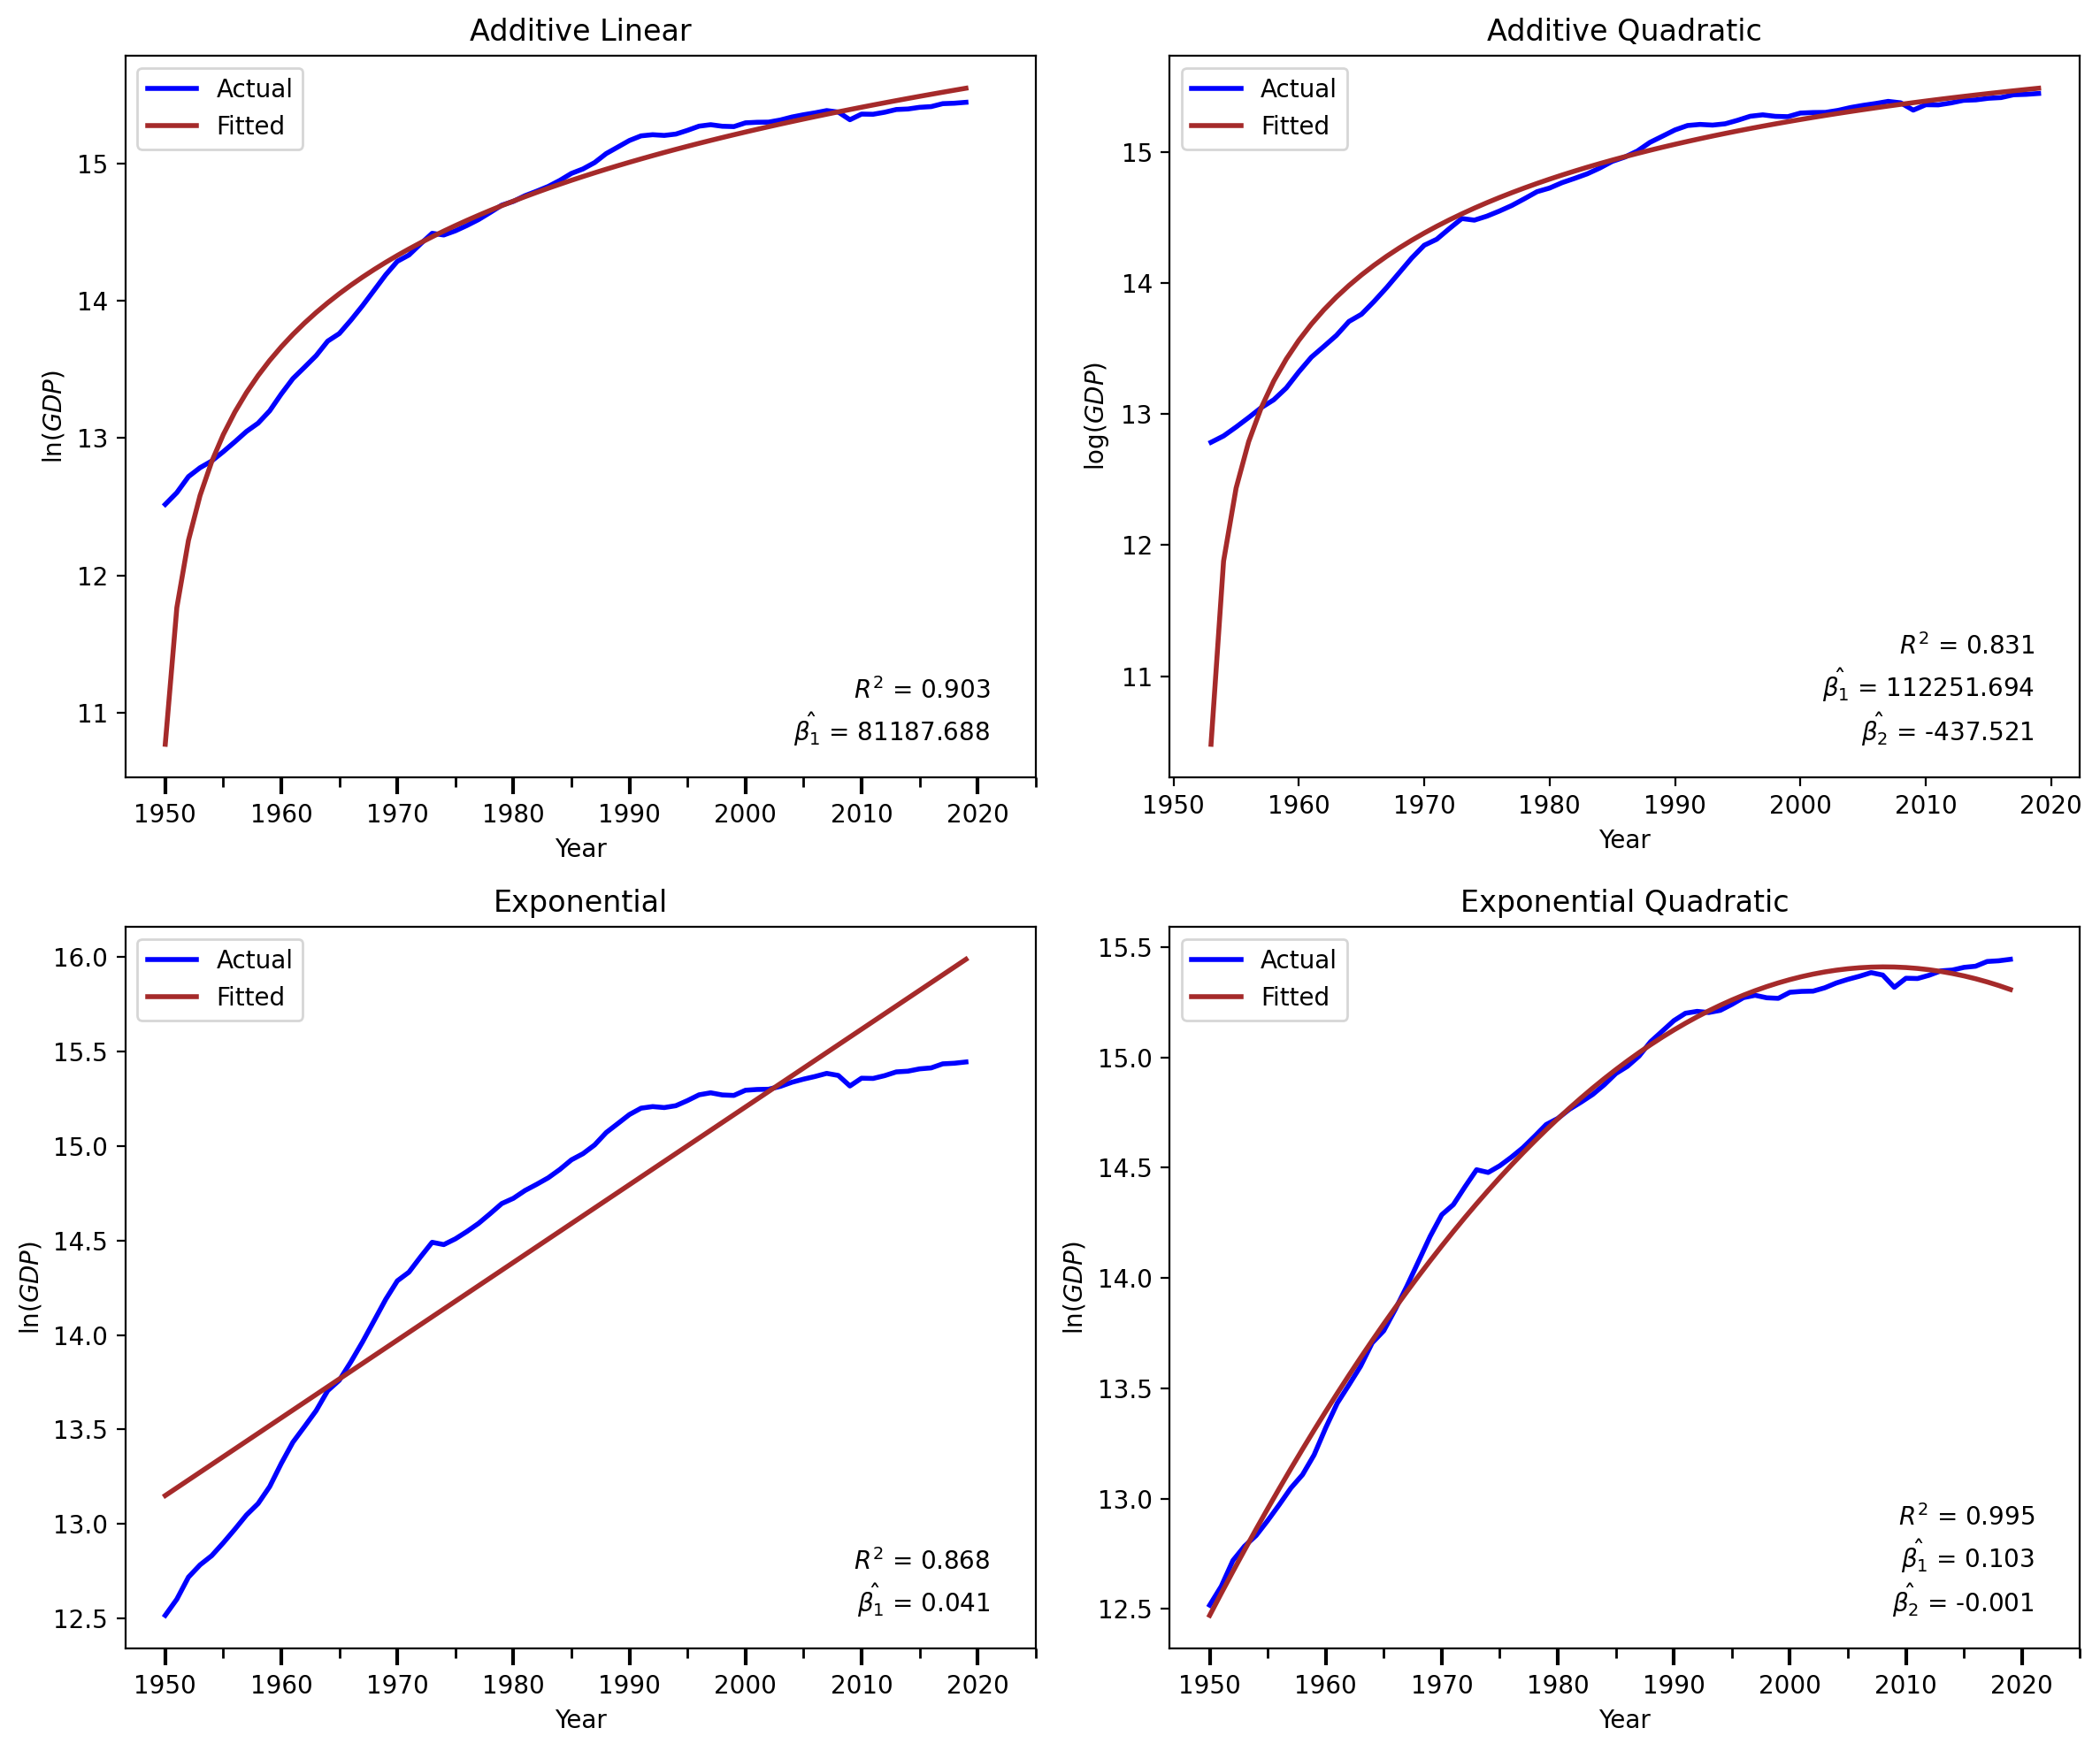

Min Yhat: -294586.7906249177
Any negative Yhat? True
Number of negative Yhat values: 3
Any zero Yhat? False
Problematic indices where Yhat <= 0: [0 1 2]
Problematic Yhat values: [-294586.79062492 -183647.65985935  -73583.57153906]
Corresponding years: [1950 1951 1952]


In [ ]:
# Loading dataset
file_path = 'PWT-data.xlsx'
data = pd.read_excel(file_path, sheet_name='Data', header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpna"]].reset_index(drop=True)

# Defining time range
ymax = 2019
ymin = 1950
data = data[(data["year"] >= ymin) & (data["year"] <= ymax)].reset_index(drop=True)

# Preparing data
years = data["year"].values
T = len(years)
T_all = ymax - ymin + 1
log_gdp = np.log(data["rgdpna"].values)  # Log-transformed real GDP

# Function to calculate predictions
def calculate_predictions(coefficients, *regressors):
    Yhat = np.empty(T_all)
    for t in range(T_all):
        Yhat[t] = sum(coefficients[i] * regressors[i][t] for i in range(len(regressors)))
    return Yhat

# Function to calculate R-squared
def calculate_r_squared(actual, predicted):
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    return 1 - (ss_residual / ss_total)

# Plotting
def plot_results(ax, model_name, actual, predicted, r2, beta_1, beta_2=None):
    ax.plot(years, actual, label="Actual", color="blue", linewidth=2)
    ax.plot(years, predicted[:T], label="Fitted", color="brown", linewidth=2)
    ax.set_title(model_name)
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$\ln(GDP)$")

    ax.set_xticks(np.arange(1950, 2030, 10))
    ax.set_xticks(np.arange(1950, 2030, 5), minor=True)
    ax.tick_params(axis='x', which='major', length=7, width=1.5, labelsize=10)
    ax.tick_params(axis='x', which='minor', length=4, width=1)

    ax.legend(loc='upper left', frameon=True, fontsize=10)

    # Adding text for R², β₁, and β₂
    text = f"$R^2$ = {r2:.3f}\n$\\hat{{\\beta_1}}$ = {beta_1:.3f}"
    if beta_2 is not None:
        text += f"\n$\\hat{{\\beta_2}}$ = {beta_2:.3f}"
    ax.text(0.95, 0.05, text, fontsize=10, ha='right', transform=ax.transAxes)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=200)
axs = axs.ravel()

# 1) Additive Linear: yt = β0 + β1t + ut
x1 = np.ones(T)
x2 = np.arange(1, T + 1)
coeffs = get_regression_coefs(data["rgdpna"].values, x1, x2)
Yhat = calculate_predictions(coeffs, x1, x2)
yhat = np.log(Yhat)
r2 = calculate_r_squared(log_gdp, yhat[:T])
plot_results(axs[0], "Additive Linear", log_gdp, yhat, r2, coeffs[1])

# 2) Additive Quadratic Model: yt = β0 + β1t + β2t² + ut
x2 = np.arange(1, T + 1)
x3 = x2 ** 2

# Computing regression coefficients and predicted values
coeffs = get_regression_coefs(data["rgdpna"].values, x1, x2, x3)
Yhat = calculate_predictions(coeffs, x1, x2, x3)

# Only keeping values where logs are possible
valid_indices = Yhat > 0
Yhat_valid = Yhat[valid_indices]  
log_gdp_valid = log_gdp[valid_indices] 

yhat_valid = np.log(Yhat_valid)

# Computing R² only using valid data
r2 = calculate_r_squared(log_gdp_valid, yhat_valid)

axs[1].plot(years[valid_indices], log_gdp_valid, label="Actual", color="blue", linewidth=2)
axs[1].plot(years[valid_indices], yhat_valid, label="Fitted", color="brown", linewidth=2)
axs[1].set_title("Additive Quadratic")
axs[1].set_xlabel("Year")
axs[1].set_ylabel(r"$\log(GDP)$")
axs[1].legend(loc="upper left", frameon=True, fontsize=10)

# Displaying R² and coefficients
text = f"$R^2$ = {r2:.3f}\n$\\hat{{\\beta_1}}$ = {coeffs[1]:.3f}\n$\\hat{{\\beta_2}}$ = {coeffs[2]:.3f}"
axs[1].text(0.95, 0.05, text, fontsize=10, ha='right', transform=axs[1].transAxes)


# 3) Exponential: log(yt) = β0 + β1t + ut
coeffs = get_regression_coefs(np.log(data["rgdpna"].values), x1, x2)
yhat = calculate_predictions(coeffs, x1, x2)
r2 = calculate_r_squared(log_gdp, yhat[:T])
plot_results(axs[2], "Exponential", log_gdp, yhat, r2, coeffs[1])

# 4) Exponential Quadratic: log(yt) = β0 + β1t + β2t² + ut
coeffs = get_regression_coefs(np.log(data["rgdpna"].values), x1, x2, x3)
yhat = calculate_predictions(coeffs, x1, x2, x3)
r2 = calculate_r_squared(log_gdp, yhat[:T])
plot_results(axs[3], "Exponential Quadratic", log_gdp, yhat, r2, coeffs[1], coeffs[2])

plt.tight_layout()
plt.show()

print("Min Yhat:", np.min(Yhat))
print("Any negative Yhat?", np.any(Yhat < 0))
print("Number of negative Yhat values:", np.sum(Yhat < 0))
print("Any zero Yhat?", np.any(Yhat == 0))

invalid_indices = np.where(Yhat <= 0)[0]
print("Problematic indices where Yhat <= 0:", invalid_indices)
print("Problematic Yhat values:", Yhat[invalid_indices])
print("Corresponding years:", years[invalid_indices])


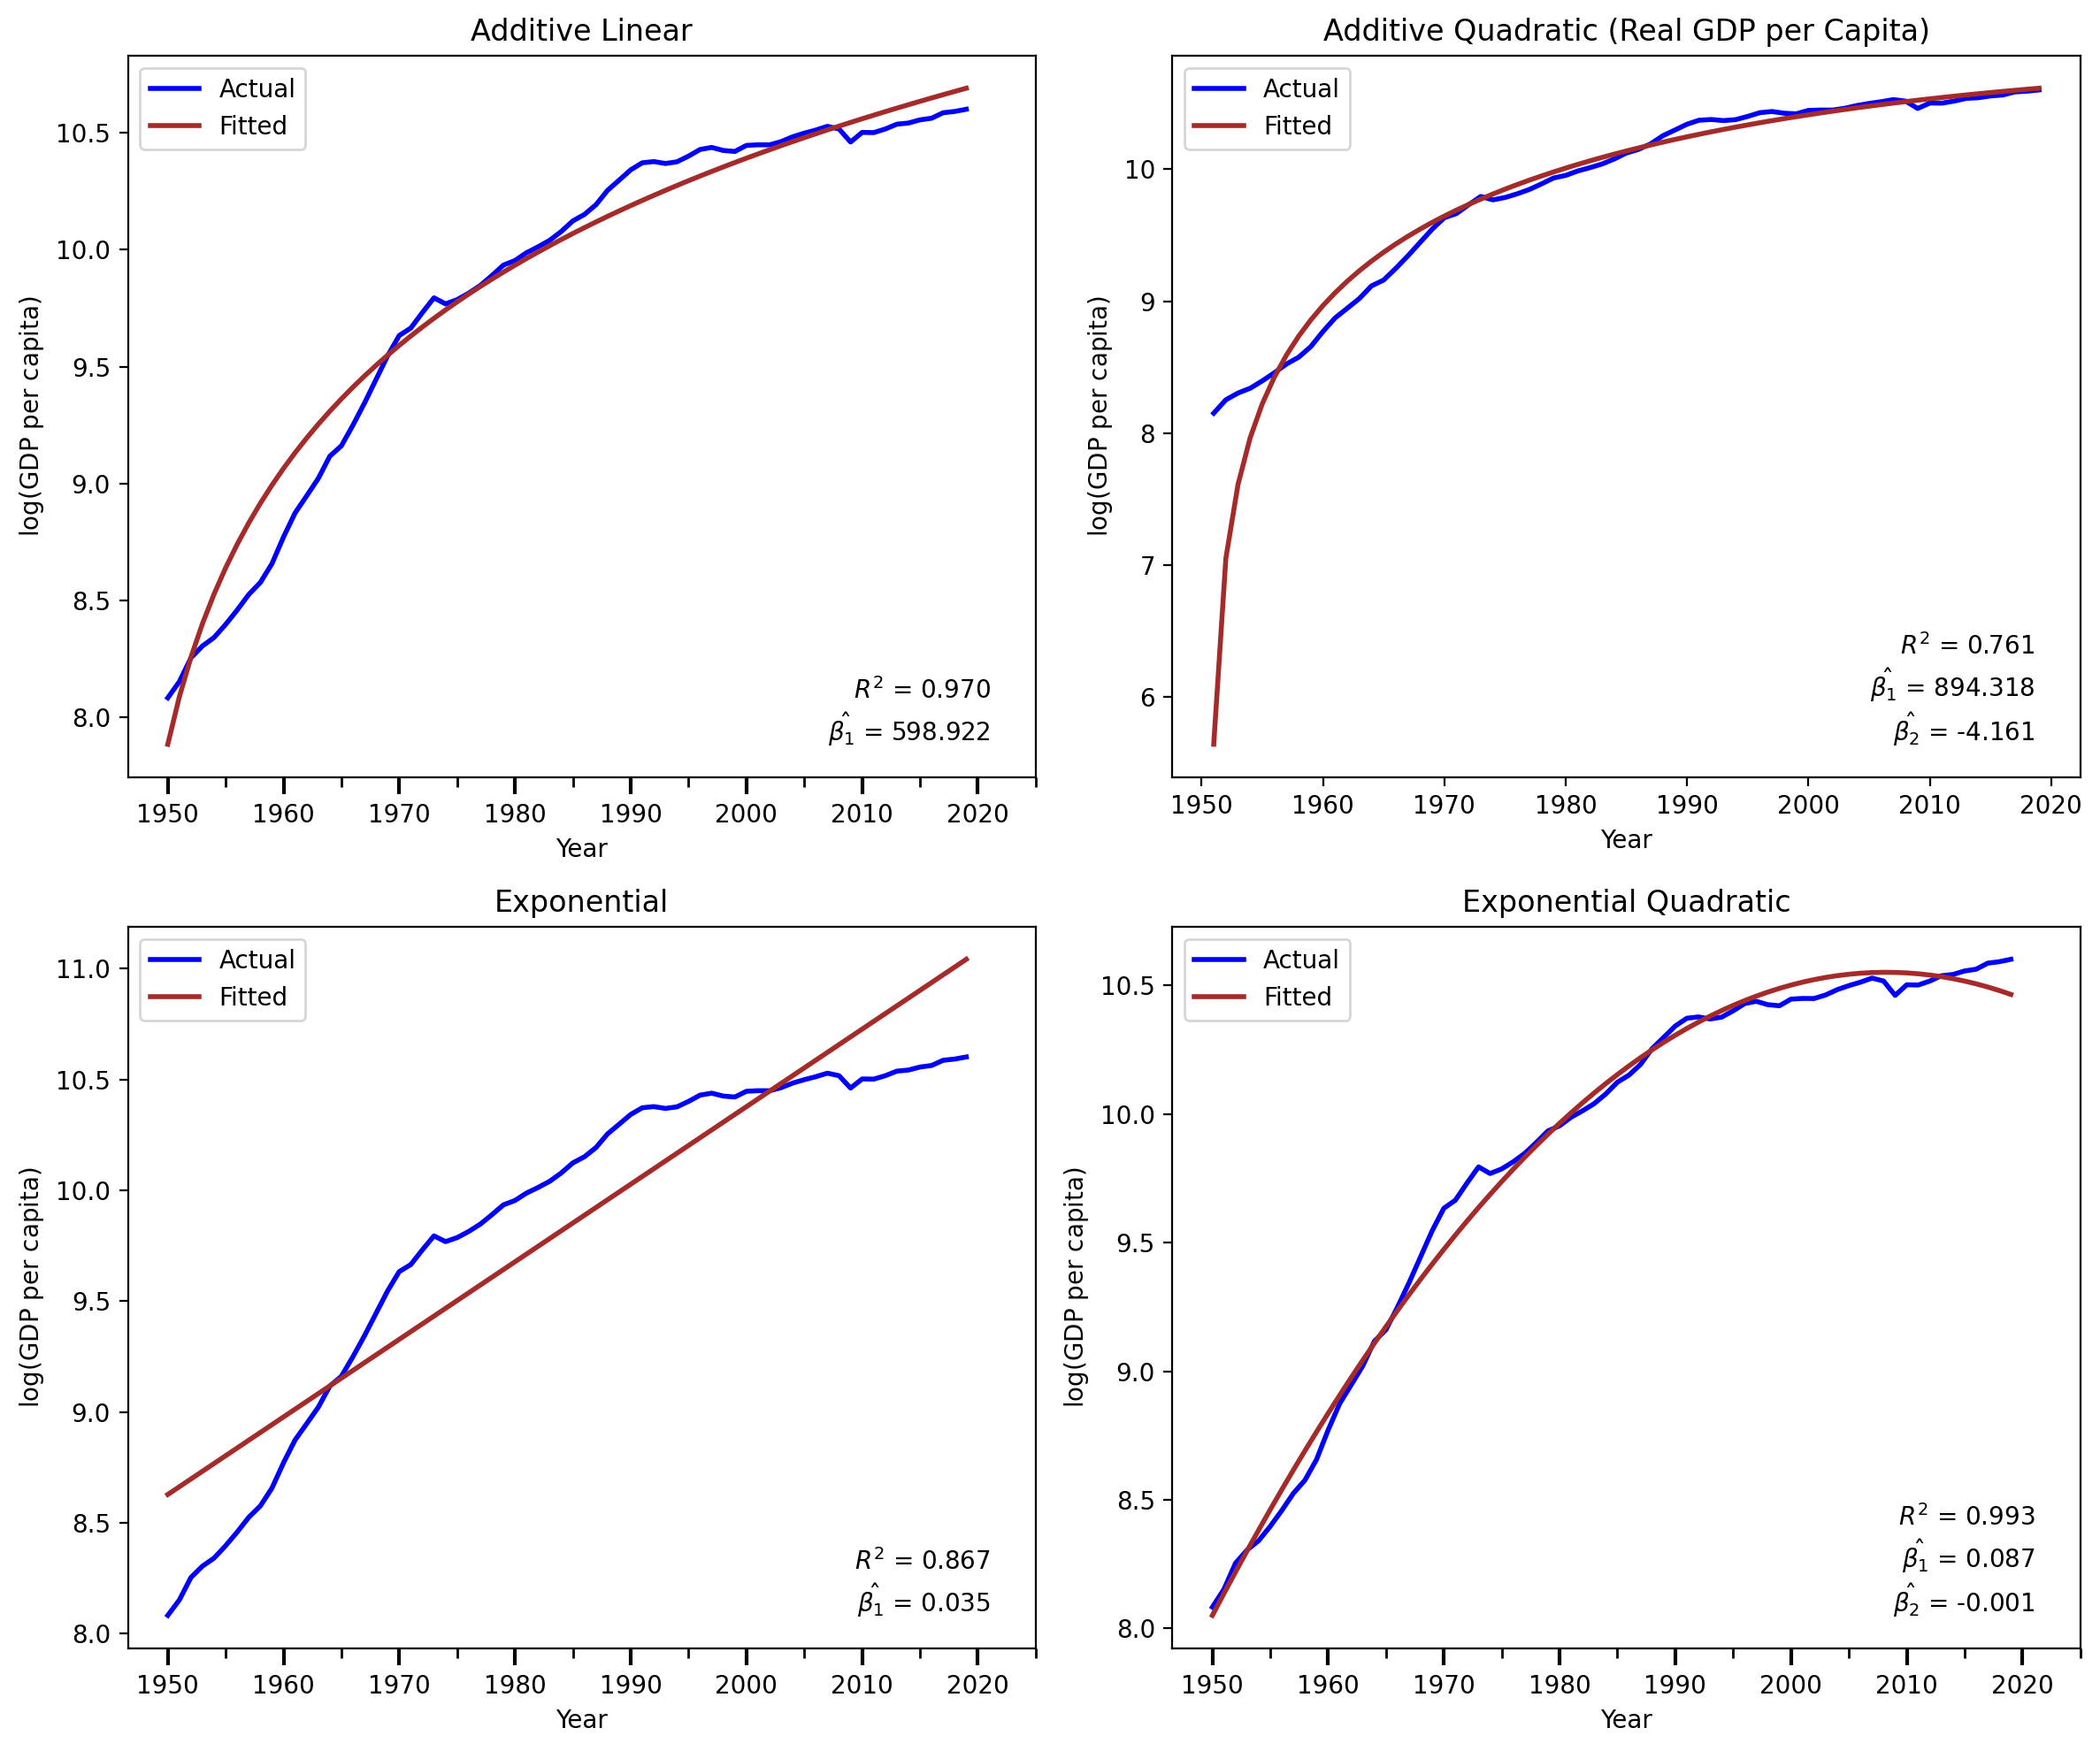

In [3]:
file_path = 'PWT-data.xlsx'
data = pd.read_excel(file_path, sheet_name='Data', header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpna", "pop"]].reset_index(drop=True)

# Calculating real GDP per capita
data["rgdp_pc"] = data["rgdpna"] / data["pop"]

# Defining year range
ymax = 2019
ymin = 1950
data = data[(data["year"] >= ymin) & (data["year"] <= ymax)].reset_index(drop=True)

years = data["year"].values
T = len(years)
T_all = ymax - ymin + 1
log_gdp_pc = np.log(data["rgdp_pc"].values)  # Log-transformed GDP per capita

# Function to calculate predictions
def calculate_predictions(coefficients, *regressors):
    Yhat = np.empty(T_all)
    for t in range(T_all):
        Yhat[t] = sum(coefficients[i] * regressors[i][t] for i in range(len(regressors)))
    return Yhat

# Function to calculate R-squared
def calculate_r_squared(actual, predicted):
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    return 1 - (ss_residual / ss_total)

# Plotting
def plot_results(ax, model_name, actual, predicted, r2, beta_1, beta_2=None):
    ax.plot(years, actual, label="Actual", color="blue", linewidth=2)
    ax.plot(years, predicted[:T], label="Fitted", color="brown", linewidth=2)
    ax.set_title(model_name)
    ax.set_xlabel("Year")
    ax.set_ylabel(r"$\log(\text{GDP}\ \text{per}\ \text{capita})$")

    ax.set_xticks(np.arange(1950, 2030, 10))
    ax.set_xticks(np.arange(1950, 2030, 5), minor=True)
    ax.tick_params(axis='x', which='major', length=7, width=1.5, labelsize=10)
    ax.tick_params(axis='x', which='minor', length=4, width=1)

    ax.legend(loc='upper left', frameon=True, fontsize=10)

    # Adding text for R², β₁, and β₂
    text = f"$R^2$ = {r2:.3f}\n$\\hat{{\\beta_1}}$ = {beta_1:.3f}"
    if beta_2 is not None:
        text += f"\n$\\hat{{\\beta_2}}$ = {beta_2:.3f}"
    ax.text(0.95, 0.05, text, fontsize=10, ha='right', transform=ax.transAxes)

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=200)
axs = axs.ravel()

# 1) Additive Linear: yt = β0 + β1t + ut
x1 = np.ones(T)
x2 = np.arange(1, T + 1)
coeffs = get_regression_coefs(data["rgdp_pc"].values, x1, x2)
Yhat = calculate_predictions(coeffs, x1, x2)
yhat = np.log(Yhat)
r2 = calculate_r_squared(log_gdp_pc, yhat[:T])
plot_results(axs[0], "Additive Linear", log_gdp_pc, yhat, r2, coeffs[1])

# 2) Additive Quadratic Model: yt = β0 + β1t + β2t² + ut
x3 = np.arange(1, T + 1) ** 2

# Computing regression coefficients and predicted values
coeffs = get_regression_coefs(data["rgdp_pc"].values, x1, x2, x3)
Yhat = calculate_predictions(coeffs, x1, x2, x3)

# Only keeping values where logs can be taken
valid_indices = Yhat > 0
Yhat_valid = Yhat[valid_indices]
log_gdp_pc_valid = log_gdp_pc[valid_indices]
yhat_valid = np.log(Yhat_valid)

# Computing R² using only valid data
r2 = calculate_r_squared(log_gdp_pc_valid, yhat_valid)

axs[1].plot(years[valid_indices], log_gdp_pc_valid, label="Actual", color="blue", linewidth=2)
axs[1].plot(years[valid_indices], yhat_valid, label="Fitted", color="brown", linewidth=2)
axs[1].set_title("Additive Quadratic (Real GDP per Capita)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel(r"$\log(\text{GDP}\ \text{per}\ \text{capita})$")
axs[1].legend(loc="upper left", frameon=True, fontsize=10)

# Displaying R² and coefficients
text = f"$R^2$ = {r2:.3f}\n$\\hat{{\\beta_1}}$ = {coeffs[1]:.3f}\n$\\hat{{\\beta_2}}$ = {coeffs[2]:.3f}"
axs[1].text(0.95, 0.05, text, fontsize=10, ha='right', transform=axs[1].transAxes)


# 3) Exponential: log(yt) = β0 + β1t + ut
coeffs = get_regression_coefs(np.log(data["rgdp_pc"].values), x1, x2)
yhat = calculate_predictions(coeffs, x1, x2)
r2 = calculate_r_squared(log_gdp_pc, yhat[:T])
plot_results(axs[2], "Exponential", log_gdp_pc, yhat, r2, coeffs[1])

# 4) Exponential Quadratic: log(yt) = β0 + β1t + β2t² + ut
coeffs = get_regression_coefs(np.log(data["rgdp_pc"].values), x1, x2, x3)
yhat = calculate_predictions(coeffs, x1, x2, x3)
r2 = calculate_r_squared(log_gdp_pc, yhat[:T])
plot_results(axs[3], "Exponential Quadratic", log_gdp_pc, yhat, r2, coeffs[1], coeffs[2])

plt.tight_layout()
plt.show()


## B — Extracting TFP Measure  

We use the standard **Cobb-Douglas production function**:  

$$
Y = A \cdot K^{\alpha} \cdot (hL)^{(1 - \alpha)}
$$

where:  
- \( Y \) denotes the **aggregate output**,  
- \( A \) represents **Total Factor Productivity (TFP)**,  
- \( K \) is the **aggregate capital stock**,  
- \( h \) is the **human capital**,  
- \( L \) represents **labour** (total number of workers).  

For our analysis, we assume:  


alpha = 0.3



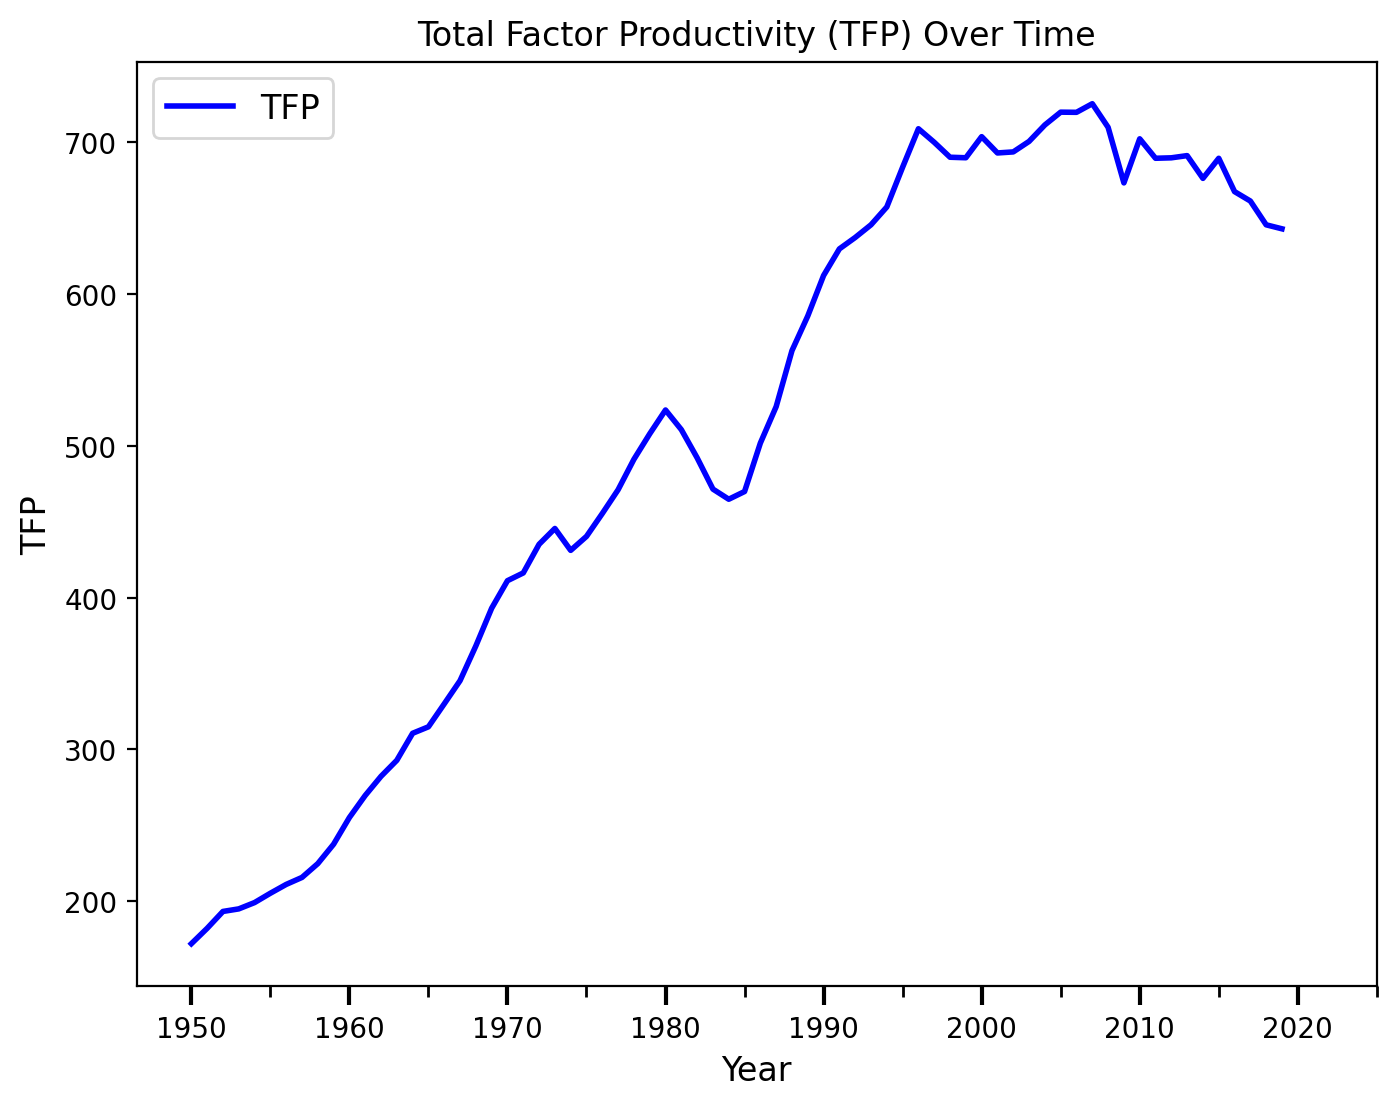

In [4]:
data = pd.read_excel(file_path, sheet_name='Data', header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "rnna", "emp", "hc"]].reset_index(drop=True)
alpha = 0.3

# Calculating TFP
data["tfp"] = data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha)))

# Extracting data for plotting
years = data["year"].values
tfp_values = data["tfp"].values

years = data["year"].values
tfp_values = data["tfp"].values

plt.figure(figsize=(8, 6), dpi=200)

plt.plot(years, tfp_values, label="TFP", color="blue", linewidth=2)

plt.title("Total Factor Productivity (TFP) Over Time")
plt.xlabel("Year", fontsize=12)
plt.ylabel("TFP", fontsize=12)

# Setting major ticks every 10 years and minor ticks every 5 years
plt.xticks(np.arange(1950, 2030, 10))
plt.gca().set_xticks(np.arange(1950, 2030, 5), minor=True)

plt.tick_params(axis='x', which='major', length=7, width=1.5, labelsize=10)
plt.tick_params(axis='x', which='minor', length=4, width=1)

plt.legend(loc='upper left', frameon=True, fontsize=12)

plt.grid(False)

plt.show()

## Checking log(TFP) results for robustness across different α values:

As results suggest, the trend in log(TFP) remains similar across different values, suggesting that results are robust to different assumptions about α.

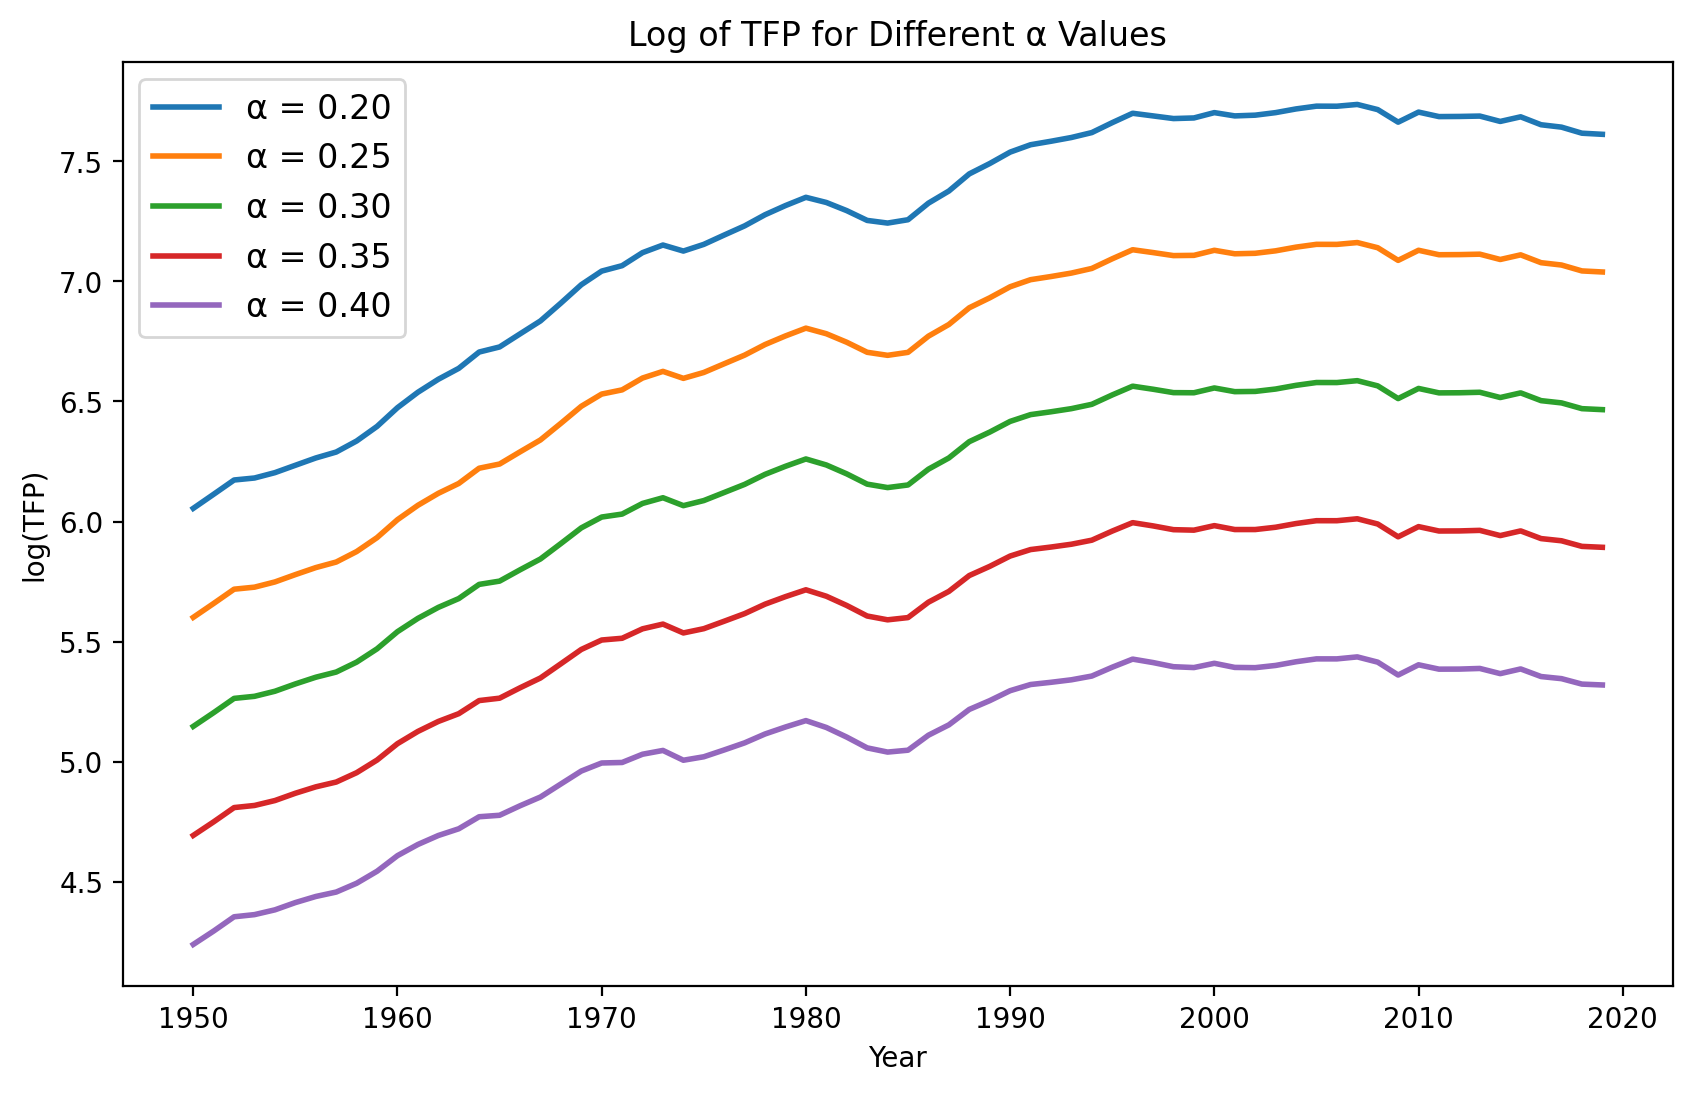

In [5]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "rnna", "emp", "hc"]].reset_index(drop=True)

# Defining alternative fixed alpha values for plotting
alpha_values = [0.2, 0.25, 0.3, 0.35, 0.4]
years = data["year"].values

plt.figure(figsize=(10, 6), dpi=200)

# Computing and plotting log-TFP for each α value
for alpha in alpha_values:
    log_tfp = np.log(data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha))))
    plt.plot(years, log_tfp, label=f"\u03B1 = {alpha:.2f}", linewidth=2)

plt.title("Log of TFP for Different \u03B1 Values")
plt.xlabel("Year")
plt.ylabel("log(TFP)")
plt.legend(loc="upper left", frameon=True, fontsize=12)
plt.grid(False)

plt.show()

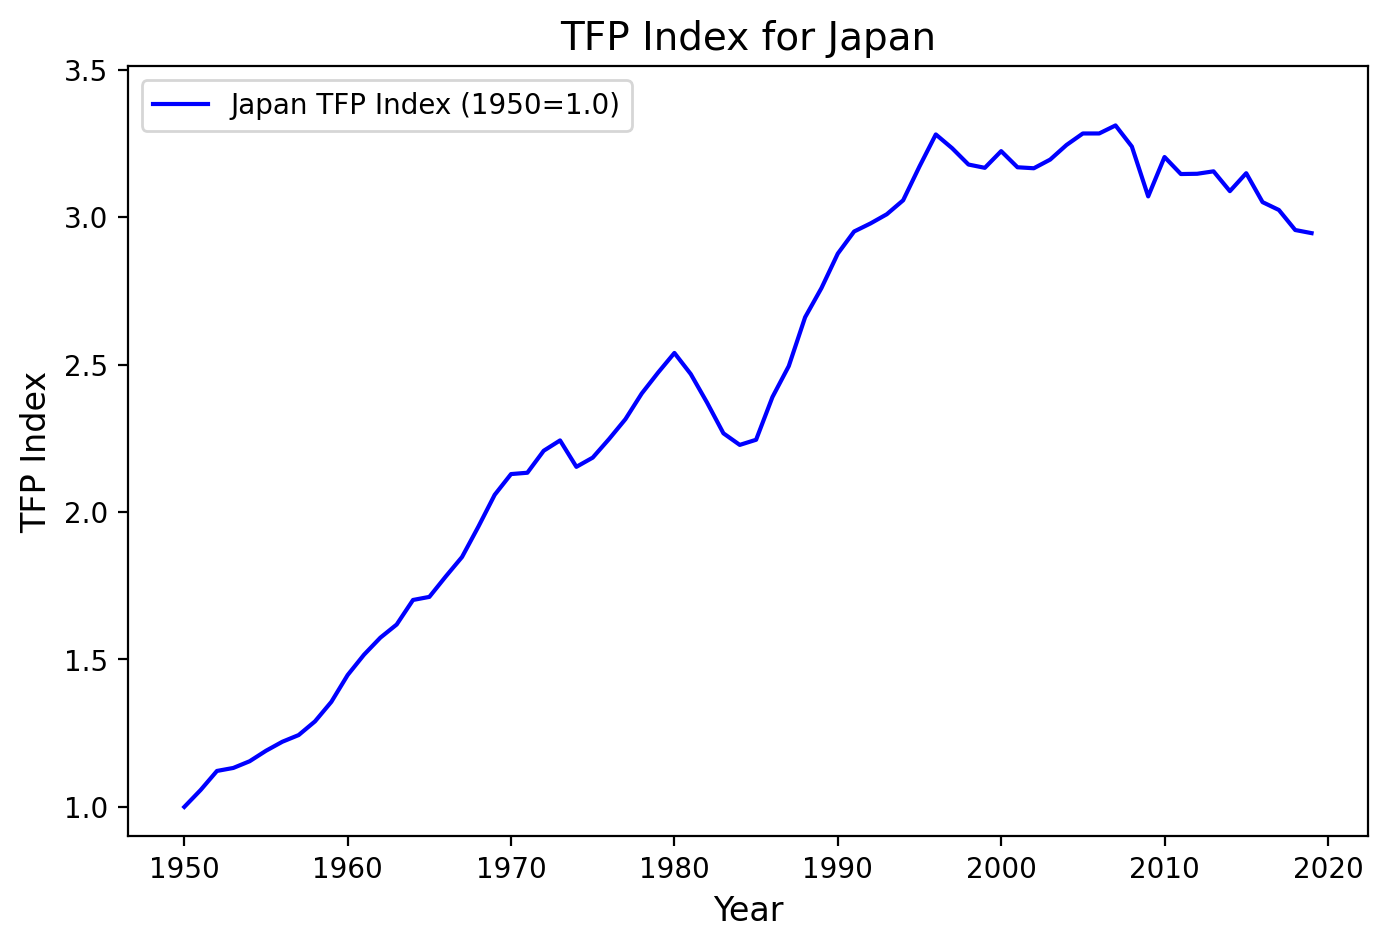

In [ ]:
# Calculating TFP
data["tfp"] = data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha)))

# Calculating TFP index (1950=1)
tfp_index = data["tfp"] / data["tfp"].iloc[0]

plt.figure(figsize=(8, 5), dpi=200)
plt.plot(data["year"], tfp_index, label="Japan TFP Index (1950=1.0)", color="blue", lw=1.5)
plt.xlabel("Year", fontsize=12)
plt.ylabel("TFP Index", fontsize=12)
plt.title("TFP Index for Japan", fontsize=14)
plt.ylim(0.9, tfp_index.max() + 0.2)
plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=10)
plt.grid(False)
plt.show()


## C — Growth Accounting


We decompose GDP growth using the following equation:

$$
\Delta \ln Y_t = \Delta \ln A_t + \alpha \Delta \ln K_t + (1 - \alpha) \Delta \ln L_t
$$

where GDP growth \( dY \) is decomposed into:

$$
\begin{aligned}
&\text{Capital contribution}: && \alpha \cdot dK \\
&\text{Labour contribution}: && (1 - \alpha) \cdot dL \\
&\text{TFP contribution}: && dA
\end{aligned}
$$

These are computed as:

$$
dY = \ln \left(\frac{Y_t}{Y_{t-1}}\right), \quad
dK = \ln \left(\frac{K_t}{K_{t-1}}\right), \quad
dL = \ln \left(\frac{L_t}{L_{t-1}}\right), \quad
dA = \ln \left(\frac{A_t}{A_{t-1}}\right)
$$



Each factor’s contribution to GDP growth is calculated as:

$$
\text{Capital Contribution} = \frac{\alpha \cdot dK}{dY}, \quad
\text{Labour Contribution} = \frac{(1 - \alpha) \cdot dL}{dY}, \quad
\text{TFP Contribution} = \frac{dA}{dY}
$$

We then check if these contributions sum to 1


In [61]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "rnna", "emp", "hc"]].reset_index(drop=True)
alpha = 0.3

# Calculating TFP (A)
data["tfp"] = data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha)))

# Converting variables to arrays
Y = data["rgdpo"].values
K = data["rnna"].values
L = (data["emp"] * data["hc"]).values
A = data["tfp"].values
years = data["year"].values

# Function to compute log growth rates
def compute_growth_rate(X):
    X = np.array(X)
    X[X <= 0] = np.nan
    return np.log(X[1:] / X[:-1])

# Computing log growth rates for Y, A, K, and L
dY = compute_growth_rate(Y)
dK = compute_growth_rate(K)
dL = compute_growth_rate(L)
dA = compute_growth_rate(A)

# Computing contributions
contrib_dK = alpha * dK / dY
contrib_dL = (1 - alpha) * dL / dY
contrib_dA = dA / dY

# Creating yearly intervals
intvls = np.array([f"{y1}-{y2}" for y1, y2 in zip(years[:-1], years[1:])])

# Combining results into a DataFrame
df_contribs = pd.DataFrame({
    "Year": intvls,
    "GDP Growth Rate (%)": dY * 100,
    "K Contribution": contrib_dK,
    "L Contribution": contrib_dL,
    "A Contribution": contrib_dA
})

# Saving results to Excel
df_contribs.to_excel("Japan_data2.xlsx", index=False)

# Calculating the sum of contributions
df_contribs["Sum"] = df_contribs["K Contribution"] + df_contribs["L Contribution"] + df_contribs["A Contribution"]

# Checking if contributions sum to 1
tolerance = 1e-5
incorrect_sums = df_contribs[np.abs(df_contribs["Sum"] - 1) > tolerance]

if not incorrect_sums.empty:
    print("\n Warning: Contributions do not sum to 1 for the following intervals:")
    print(tabulate(incorrect_sums, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))

print("\n== Contributions Table ==\n")
print(tabulate(df_contribs, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))


== Contributions Table ==

╒════╤═══════════╤═══════════════════════╤══════════════════╤══════════════════╤══════════════════╤════════╕
│    │ Year      │   GDP Growth Rate (%) │   K Contribution │   L Contribution │   A Contribution │    Sum │
╞════╪═══════════╪═══════════════════════╪══════════════════╪══════════════════╪══════════════════╪════════╡
│  0 │ 1950-1951 │               10.0172 │           0.1585 │           0.2697 │           0.5718 │ 1.0000 │
├────┼───────────┼───────────────────────┼──────────────────┼──────────────────┼──────────────────┼────────┤
│  1 │ 1951-1952 │                9.6795 │           0.1157 │           0.2714 │           0.6129 │ 1.0000 │
├────┼───────────┼───────────────────────┼──────────────────┼──────────────────┼──────────────────┼────────┤
│  2 │ 1952-1953 │                4.3739 │           0.2243 │           0.5779 │           0.1978 │ 1.0000 │
├────┼───────────┼───────────────────────┼──────────────────┼──────────────────┼──────────────────┼─

## Calculating and displaying growth rates for GDP, capital, labour and TFP


In [32]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "rnna", "emp", "hc"]].reset_index(drop=True)
alpha = 0.3

# Calculating TFP (A)
data["tfp"] = data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha)))

# Converting variables to arrays
Y = data["rgdpo"].values
K = data["rnna"].values
L = (data["emp"] * data["hc"]).values
A = data["tfp"].values
years = data["year"].values

# Function to compute log growth rates safely
def compute_growth_rate(X):
    X = np.array(X)
    X[X <= 0] = np.nan
    return np.log(X[1:] / X[:-1])

# Computing log growth rates for Y, A, K, and L
dY = compute_growth_rate(Y)
dK = compute_growth_rate(K)
dL = compute_growth_rate(L)
dA = compute_growth_rate(A)

# Creating yearly intervals
intvls = np.array([f"{y1}-{y2}" for y1, y2 in zip(years[:-1], years[1:])])

# Combining results into a DataFrame
df_growths = pd.DataFrame({
    "Year": intvls,
    "Growth Y": dY,
    "Growth K": dK,
    "Growth L": dL,
    "Growth A": dA
})

print("\n== Table with Growth Rates ==\n")
print(tabulate(df_growths, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))



== Table with Growth Rates ==

╒════╤═══════════╤════════════╤════════════╤════════════╤════════════╕
│    │ Year      │   Growth Y │   Growth K │   Growth L │   Growth A │
╞════╪═══════════╪════════════╪════════════╪════════════╪════════════╡
│  0 │ 1950-1951 │     0.1002 │     0.0529 │     0.0386 │     0.0573 │
├────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│  1 │ 1951-1952 │     0.0968 │     0.0373 │     0.0375 │     0.0593 │
├────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│  2 │ 1952-1953 │     0.0437 │     0.0327 │     0.0361 │     0.0087 │
├────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│  3 │ 1953-1954 │     0.0516 │     0.0391 │     0.0268 │     0.0211 │
├────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│  4 │ 1954-1955 │     0.0766 │     0.0475 │     0.0456 │     0.0304 │
├────┼───────────┼────────────┼────────────┼────────────┼────────────┤
│  5 │ 1955-1956 │     0.0660 │     0.0558 │ 

# Visualising Growth Contributions Over Time

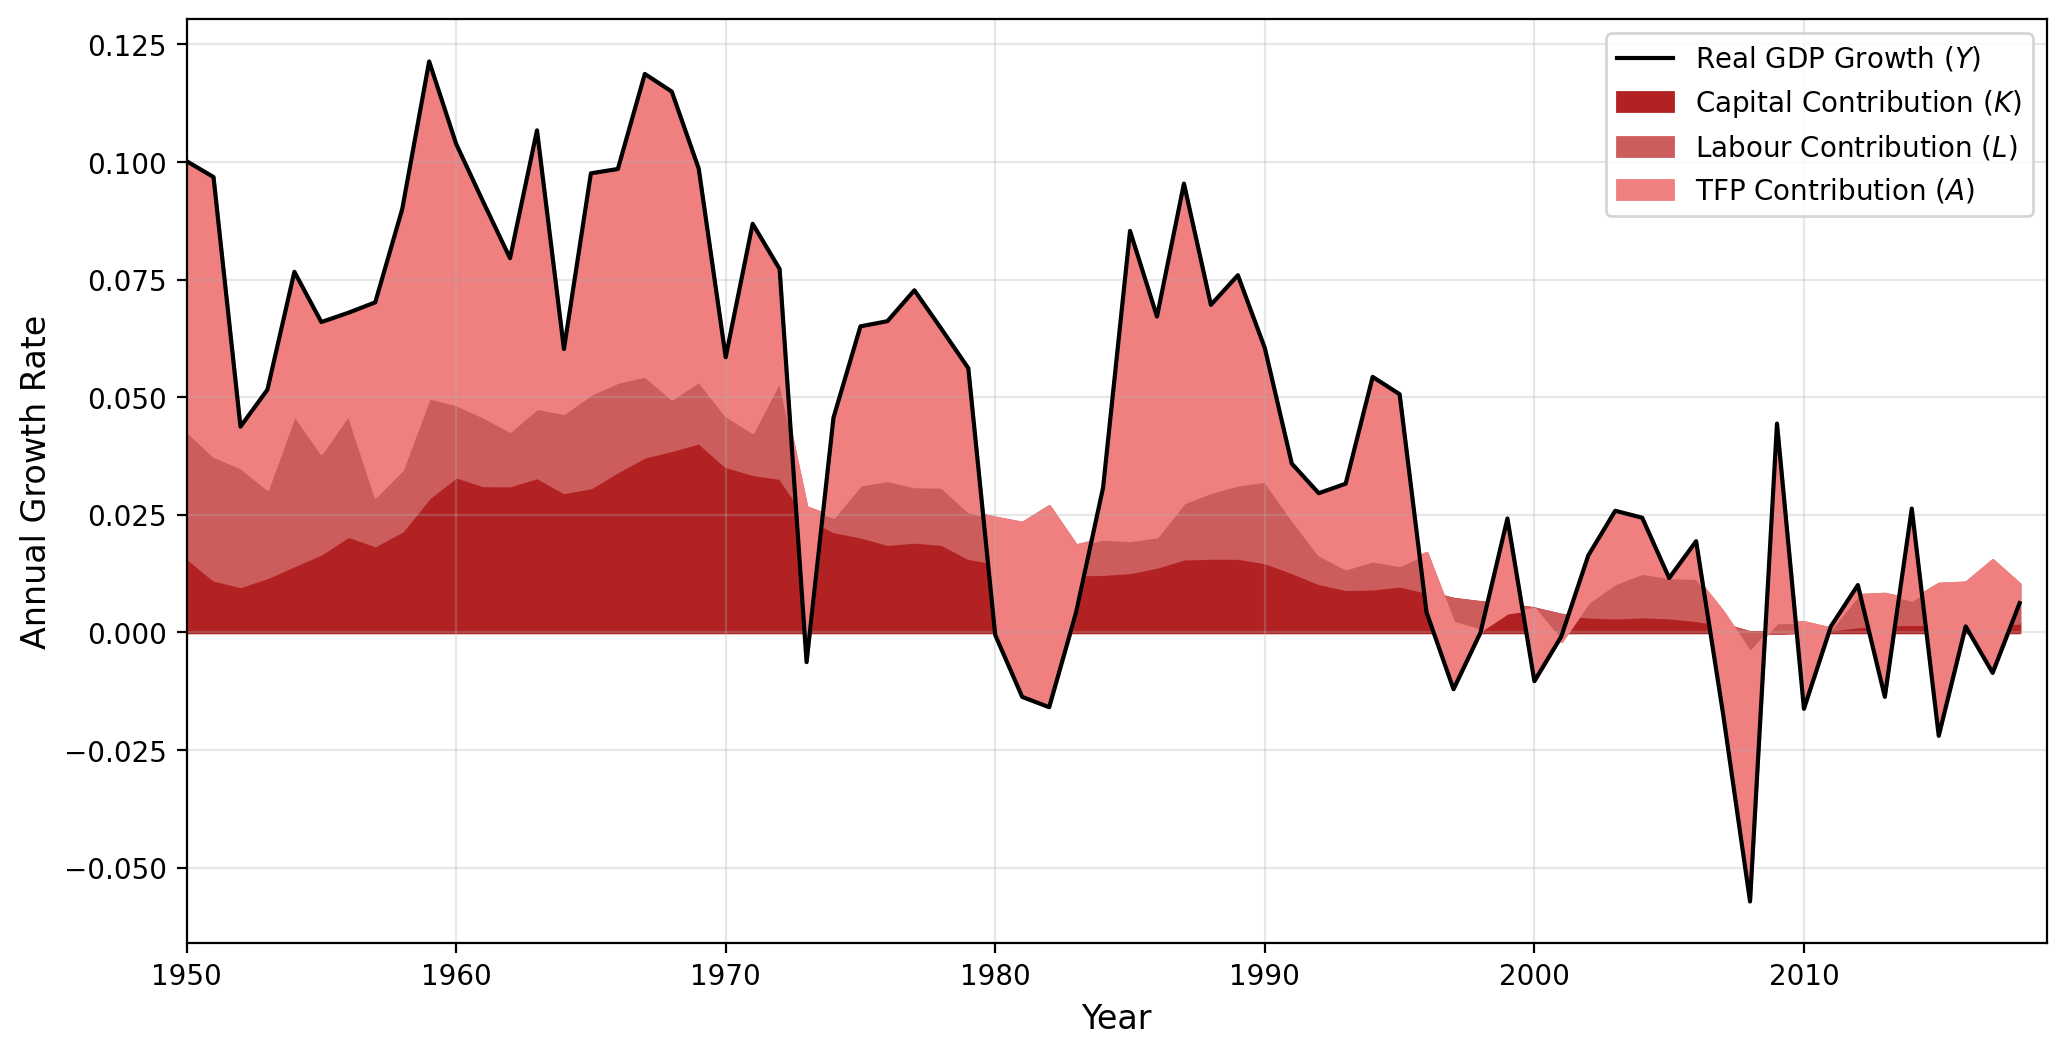

In [ ]:
colors = {
    "K": "firebrick",        # Dark red for capital contribution
    "L": "indianred",        # Medium red for labour contribution
    "A": "lightcoral"        # Light red for TFP contribution
}

plt.figure(figsize=(12,6), dpi=200)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Growth Rate", fontsize=12)

# Plotting Real GDP growth rate (Y) as a black line
plt.plot(years[:-1], dY, color="black", linewidth=1.5, label="Real GDP Growth ($Y$)")

# Stacked area for contributions
plt.fill_between(years[:-1], 0, alpha * dK, color=colors["K"], label="Capital Contribution ($K$)")
plt.fill_between(years[:-1], alpha * dK, (1 - alpha) * dL + alpha * dK, color=colors["L"], label="Labour Contribution ($L$)")
plt.fill_between(years[:-1], (1 - alpha) * dL + alpha * dK, dA + (1 - alpha) * dL + alpha * dK, color=colors["A"], label="TFP Contribution ($A$)")

plt.xlim(1950, 2019)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.show()

# **Long-term Growth Decomposition**

These scripts decompose GDP growth into contributions of A, L and K for longer periods. Note that we have split the analysis into two parts - **(1)** 10 year periods and **(2)** custom periods 1950 - 1973 (rapid expansion after WWII), 1973 - 1990 (bubble economy), 1990 - 2010 (the lost decade and deflation) and 2010 - 2019 (Abenomics era) which are more alligned with the context of the Japanese economy. 

### Steps:
1. The dataset is divided into 10-year intervals
2. Computing Annual Growth Rates using Log differences 
3. Calculating contributions
4. Applying Weighted Averaging: Each year's contribution is weighted by its share of total GDP growth in the period

We also ensured that all contributions sum up to 1 for each period, providing a robust long-term growth analysis.


In [44]:
def generate_periods(years, step=10):
    return [(i, min(i + step, len(years) - 1)) for i in np.arange(0, len(years), step)]

# Computing annual log growth rates safely
def compute_growth_rate(X):
    X = np.array(X)
    X[X <= 0] = np.nan
    return np.log(X[1:] / X[:-1])

# Computing annual contributions
def compute_annual_contributions():
    dY = compute_growth_rate(Y)
    dK = compute_growth_rate(K)
    dL = compute_growth_rate(L)
    dA = compute_growth_rate(A)

    contrib_dK = alpha * dK / dY
    contrib_dL = (1 - alpha) * dL / dY
    contrib_dA = dA / dY

    return dY, contrib_dK, contrib_dL, contrib_dA

# Function to compute weighted contributions for longer periods
def longer_period_contributions(start_idx, end_idx):
    period = f"{years[start_idx]}-{years[end_idx]}"

    # Getting growth rates and contributions for each year in the period
    period_Y_growth = np.log(Y[end_idx] / Y[start_idx])
    dY_period = dY[start_idx:end_idx]

    # Computing weights for each year in the period
    weights = dY_period / period_Y_growth

    # Multiplying weights by each year's contributions
    K_contrib_weighted = np.nansum(weights * contrib_dK[start_idx:end_idx])
    L_contrib_weighted = np.nansum(weights * contrib_dL[start_idx:end_idx])
    A_contrib_weighted = np.nansum(weights * contrib_dA[start_idx:end_idx])

    return period, K_contrib_weighted, L_contrib_weighted, A_contrib_weighted, period_Y_growth

# Computing annual growth rates and contributions
dY, contrib_dK, contrib_dL, contrib_dA = compute_annual_contributions()

periods = generate_periods(years, step=10)

# Computing longer-period contributions with weighted averaging
results = [longer_period_contributions(start, end) for start, end in periods]
df_periods = pd.DataFrame(results, columns=["Year", "K Contribution", "L Contribution", "A Contribution", "Y Growth"])
print("\n== Longer Period Contributions ==\n")
print(tabulate(df_periods, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))



== Longer Period Contributions ==

╒════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤════════════╕
│    │ Year      │   K Contribution │   L Contribution │   A Contribution │   Y Growth │
╞════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪════════════╡
│  0 │ 1950-1960 │           0.2153 │           0.2819 │           0.5028 │     0.7843 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  1 │ 1960-1970 │           0.3503 │           0.1578 │           0.4918 │     0.9702 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  2 │ 1970-1980 │           0.4103 │           0.1775 │           0.4122 │     0.5866 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  3 │ 1980-1990 │           0.3501 │           0.2574 │           0.3926 │     0.3983 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────

In [47]:
# Defining specific periods for analysis
longer_periods = [(1950, 1973), (1973, 1990), (1990, 2010), (2010, 2019)]
alpha = 0.3

# Function to compute log growth rates safely
def compute_growth_rate(X):
    X = np.array(X, dtype=np.float64)
    X[X <= 0] = np.nan 
    return np.log(X[1:] / X[:-1])

# Computing annual contributions
def compute_annual_contributions():
    dY = compute_growth_rate(Y)
    dK = compute_growth_rate(K)
    dL = compute_growth_rate(L)
    dA = compute_growth_rate(A)

    contrib_dK = alpha * dK / dY
    contrib_dL = (1 - alpha) * dL / dY
    contrib_dA = dA / dY

    return dY, contrib_dK, contrib_dL, contrib_dA

# Function to compute weighted contributions for longer periods
def longer_period_contributions(start_year, end_year):
    start_idx = np.where(years == start_year)[0][0]
    end_idx = np.where(years == end_year)[0][0]

    period = f"{start_year}-{end_year}"

    # Computing total GDP growth over the period
    period_Y_growth = np.log(Y[end_idx] / Y[start_idx])
    dY_period = dY[start_idx:end_idx]

    # Computing weights for each year within the period
    weights = dY_period / period_Y_growth

    # Computing weighted contributions
    K_contrib_weighted = np.nansum(weights * contrib_dK[start_idx:end_idx])
    L_contrib_weighted = np.nansum(weights * contrib_dL[start_idx:end_idx])
    A_contrib_weighted = np.nansum(weights * contrib_dA[start_idx:end_idx])

    return period, K_contrib_weighted, L_contrib_weighted, A_contrib_weighted, period_Y_growth

# Computing annual growth rates and contributions
dY, contrib_dK, contrib_dL, contrib_dA = compute_annual_contributions()

# Computing longer-period contributions with weighted averaging
results = [longer_period_contributions(start, end) for start, end in longer_periods]
df_periods = pd.DataFrame(results, columns=["Year", "K Contribution", "L Contribution", "A Contribution", "Y Growth"])

print("\n== Longer Period Contributions ==\n")
print(tabulate(df_periods, headers="keys", tablefmt="fancy_grid", floatfmt=".4f"))



== Longer Period Contributions ==

╒════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤════════════╕
│    │ Year      │   K Contribution │   L Contribution │   A Contribution │   Y Growth │
╞════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪════════════╡
│  0 │ 1950-1973 │           0.3088 │           0.2097 │           0.4815 │     1.9772 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  1 │ 1973-1990 │           0.3651 │           0.2180 │           0.4169 │     0.7622 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  2 │ 1990-2010 │           0.3612 │           0.2291 │           0.4097 │     0.3350 │
├────┼───────────┼──────────────────┼──────────────────┼──────────────────┼────────────┤
│  3 │ 2010-2019 │          -0.8490 │          -3.9084 │           5.7574 │    -0.0153 │
╘════╧═══════════╧══════════════════╧══════════════════╧══════════════════

## The below script converts the above-calculated contributions into percetages

The representation here is in relative terms, which doesn't showcase the direction (positive or negative) of the particular contribution.

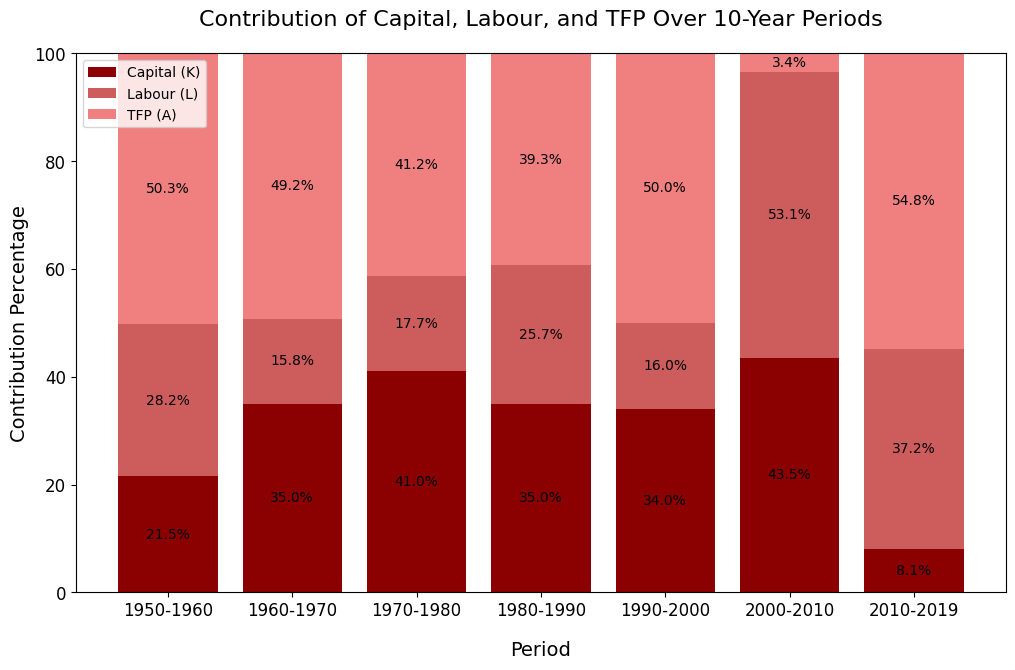

In [48]:
ten_year_periods = [(1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990), (1990, 2000), (2000, 2010), (2010, 2019)]
alpha = 0.3

# Function to compute contributions over a given period
def longer_period_contributions(start_year, end_year, data):
    start_idx = data[data["year"] == start_year].index[0]
    end_idx = data[data["year"] == end_year].index[0]

    period = f"{start_year}-{end_year}"

    Y_start, Y_end = data["rgdpo"].iloc[start_idx], data["rgdpo"].iloc[end_idx]
    K_start, K_end = data["rnna"].iloc[start_idx], data["rnna"].iloc[end_idx]
    L_start, L_end = data["hc"].iloc[start_idx] * data["emp"].iloc[start_idx], data["hc"].iloc[end_idx] * data["emp"].iloc[end_idx]
    A_start, A_end = data["tfp"].iloc[start_idx], data["tfp"].iloc[end_idx]

    # Calculating growth rates
    Y_growth = np.log(Y_end / Y_start)
    K_contrib = (alpha * np.log(K_end / K_start)) / Y_growth
    L_contrib = ((1 - alpha) * np.log(L_end / L_start)) / Y_growth
    A_contrib = (np.log(A_end / A_start)) / Y_growth

    return period, K_contrib, L_contrib, A_contrib, Y_growth

# Computing results
results = [longer_period_contributions(start, end, data) for start, end in ten_year_periods]

df = pd.DataFrame(results, columns=["Period", "Capital (K)", "Labor (L)", "TFP (A)", "Y Growth"])

# Converting contributions to percentage terms
df["Total Abs"] = abs(df["Capital (K)"]) + abs(df["Labor (L)"]) + abs(df["TFP (A)"])
df["Capital (K) %"] = abs(df["Capital (K)"]) / df["Total Abs"] * 100
df["Labour (L) %"] = abs(df["Labor (L)"]) / df["Total Abs"] * 100
df["TFP (A) %"] = abs(df["TFP (A)"]) / df["Total Abs"] * 100

# Plotting Contributions in Percentage Terms
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(df))
colors = ['#8B0000', '#CD5C5C', '#F08080']

for i, col in enumerate(["Capital (K) %", "Labour (L) %", "TFP (A) %"]):
    bars = ax.bar(df["Period"], df[col], bottom=bottom, label=col[:-2], color=colors[i])

    # Adding percentage labels inside bars
    for bar, value in zip(bars, df[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                f'{value:.1f}%', ha='center', va='center', fontsize=10, color='black')

    bottom += df[col].values

ax.set_xlabel("Period", fontsize=14, labelpad=15)
ax.set_ylabel("Contribution Percentage", fontsize=14)
ax.set_title("Contribution of Capital, Labour, and TFP Over 10-Year Periods", fontsize=16, pad=20)
ax.legend(loc="upper left", fontsize=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)
plt.grid(False)
plt.show()


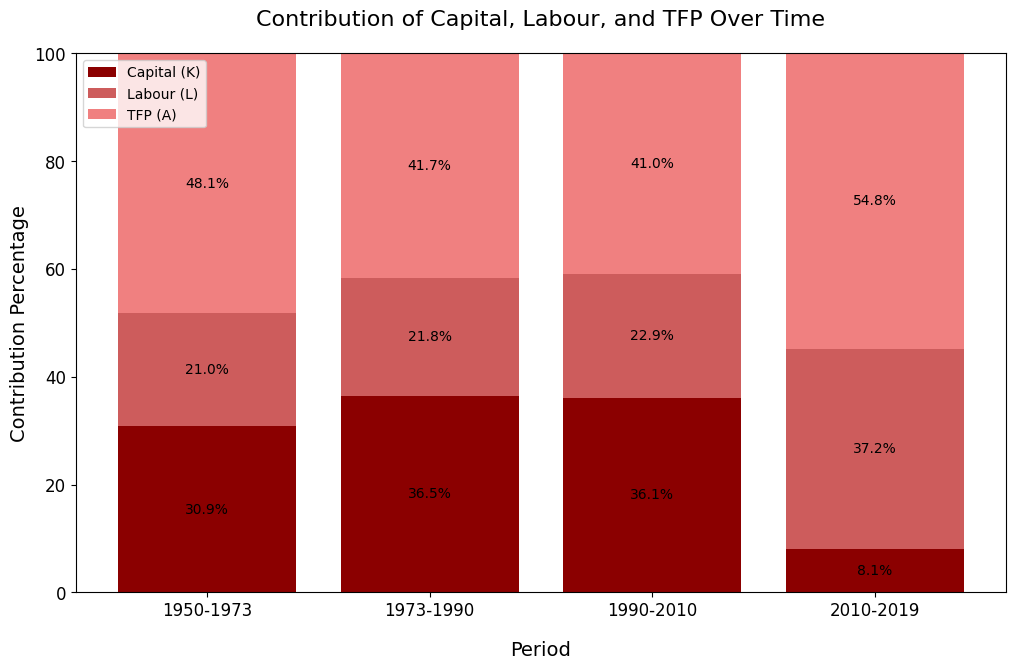

In [50]:
periods = [(1950, 1973), (1973, 1990), (1990, 2010), (2010, 2019)]
alpha = 0.3

# Function to compute contributions over a given period
def longer_period_contributions(start_year, end_year, data):
    start_idx = data[data["year"] == start_year].index[0]
    end_idx = data[data["year"] == end_year].index[0]

    period = f"{start_year}-{end_year}"

    Y_start, Y_end = data["rgdpo"].iloc[start_idx], data["rgdpo"].iloc[end_idx]
    K_start, K_end = data["rnna"].iloc[start_idx], data["rnna"].iloc[end_idx]
    L_start, L_end = data["hc"].iloc[start_idx] * data["emp"].iloc[start_idx], data["hc"].iloc[end_idx] * data["emp"].iloc[end_idx]
    A_start, A_end = data["tfp"].iloc[start_idx], data["tfp"].iloc[end_idx]

    # Calculating growth rates
    Y_growth = np.log(Y_end / Y_start)
    K_contrib = (alpha * np.log(K_end / K_start)) / Y_growth
    L_contrib = ((1 - alpha) * np.log(L_end / L_start)) / Y_growth
    A_contrib = (np.log(A_end / A_start)) / Y_growth

    return period, K_contrib, L_contrib, A_contrib, Y_growth

results = [longer_period_contributions(start, end, data) for start, end in periods]

df = pd.DataFrame(results, columns=["Period", "Capital (K)", "Labour (L)", "TFP (A)", "Y Growth"])

# Converting contributions to percentage terms
df["Total Abs"] = abs(df["Capital (K)"]) + abs(df["Labour (L)"]) + abs(df["TFP (A)"])
df["Capital (K) %"] = abs(df["Capital (K)"]) / df["Total Abs"] * 100
df["Labour (L) %"] = abs(df["Labour (L)"]) / df["Total Abs"] * 100
df["TFP (A) %"] = abs(df["TFP (A)"]) / df["Total Abs"] * 100

# Plotting Contributions in Percentage Terms
fig, ax = plt.subplots(figsize=(12, 7))
bottom = np.zeros(len(df))
colors = ['#8B0000', '#CD5C5C', '#F08080']

for i, col in enumerate(["Capital (K) %", "Labour (L) %", "TFP (A) %"]):
    bars = ax.bar(df["Period"], df[col], bottom=bottom, label=col[:-2], color=colors[i])

    # Adding percentage labels inside bars
    for bar, value in zip(bars, df[col]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                f'{value:.1f}%', ha='center', va='center', fontsize=10, color='black')

    bottom += df[col].values

ax.set_xlabel("Period", fontsize=14, labelpad=15)
ax.set_ylabel("Contribution Percentage", fontsize=14)
ax.set_title("Contribution of Capital, Labour, and TFP Over Time", fontsize=16, pad=20)
ax.legend(loc="upper left", fontsize=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)
plt.grid(False)
plt.show()


## D - Constructing a series for labour productivity, using real GDP per worker as a measure

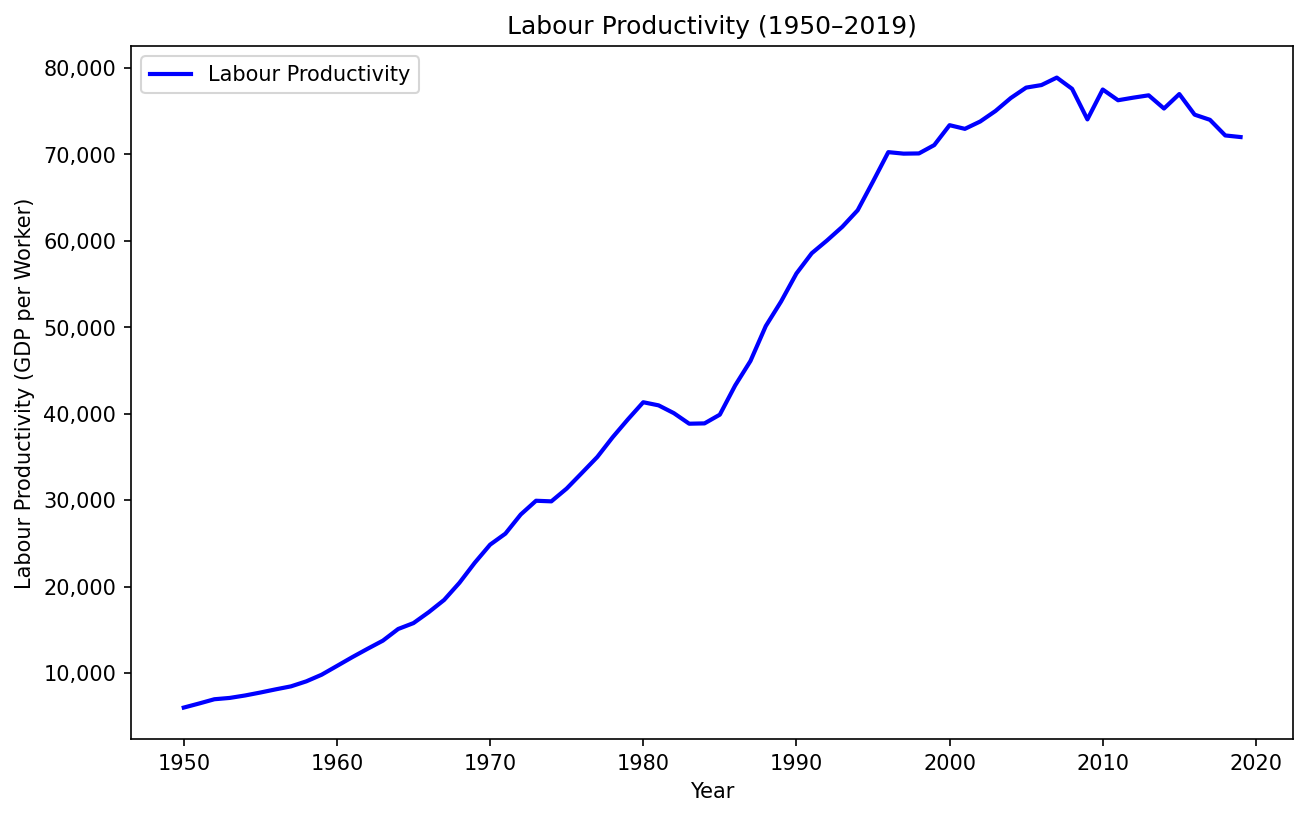

In [ ]:
# Selecting data
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "emp"]].reset_index(drop=True)
data["labour_productivity"] = data["rgdpo"] / data["emp"]

# Computing labour productivity
labour_productivity = data["labour_productivity"].values

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(data["year"], data["labour_productivity"], label="Labour Productivity", color="blue", linewidth=2)
plt.xlabel("Year")
plt.ylabel("Labour Productivity (GDP per Worker)")
plt.title("Labour Productivity (1950–2019)")
plt.grid(alpha=0.3)
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(False)
plt.show()


## Visualising a conversion hypothesis for a Solow Model

The scatter plot represents the dynamics of the growth in real GDP per capita versus the real GDP per capita with a negative sloping line of best fit 

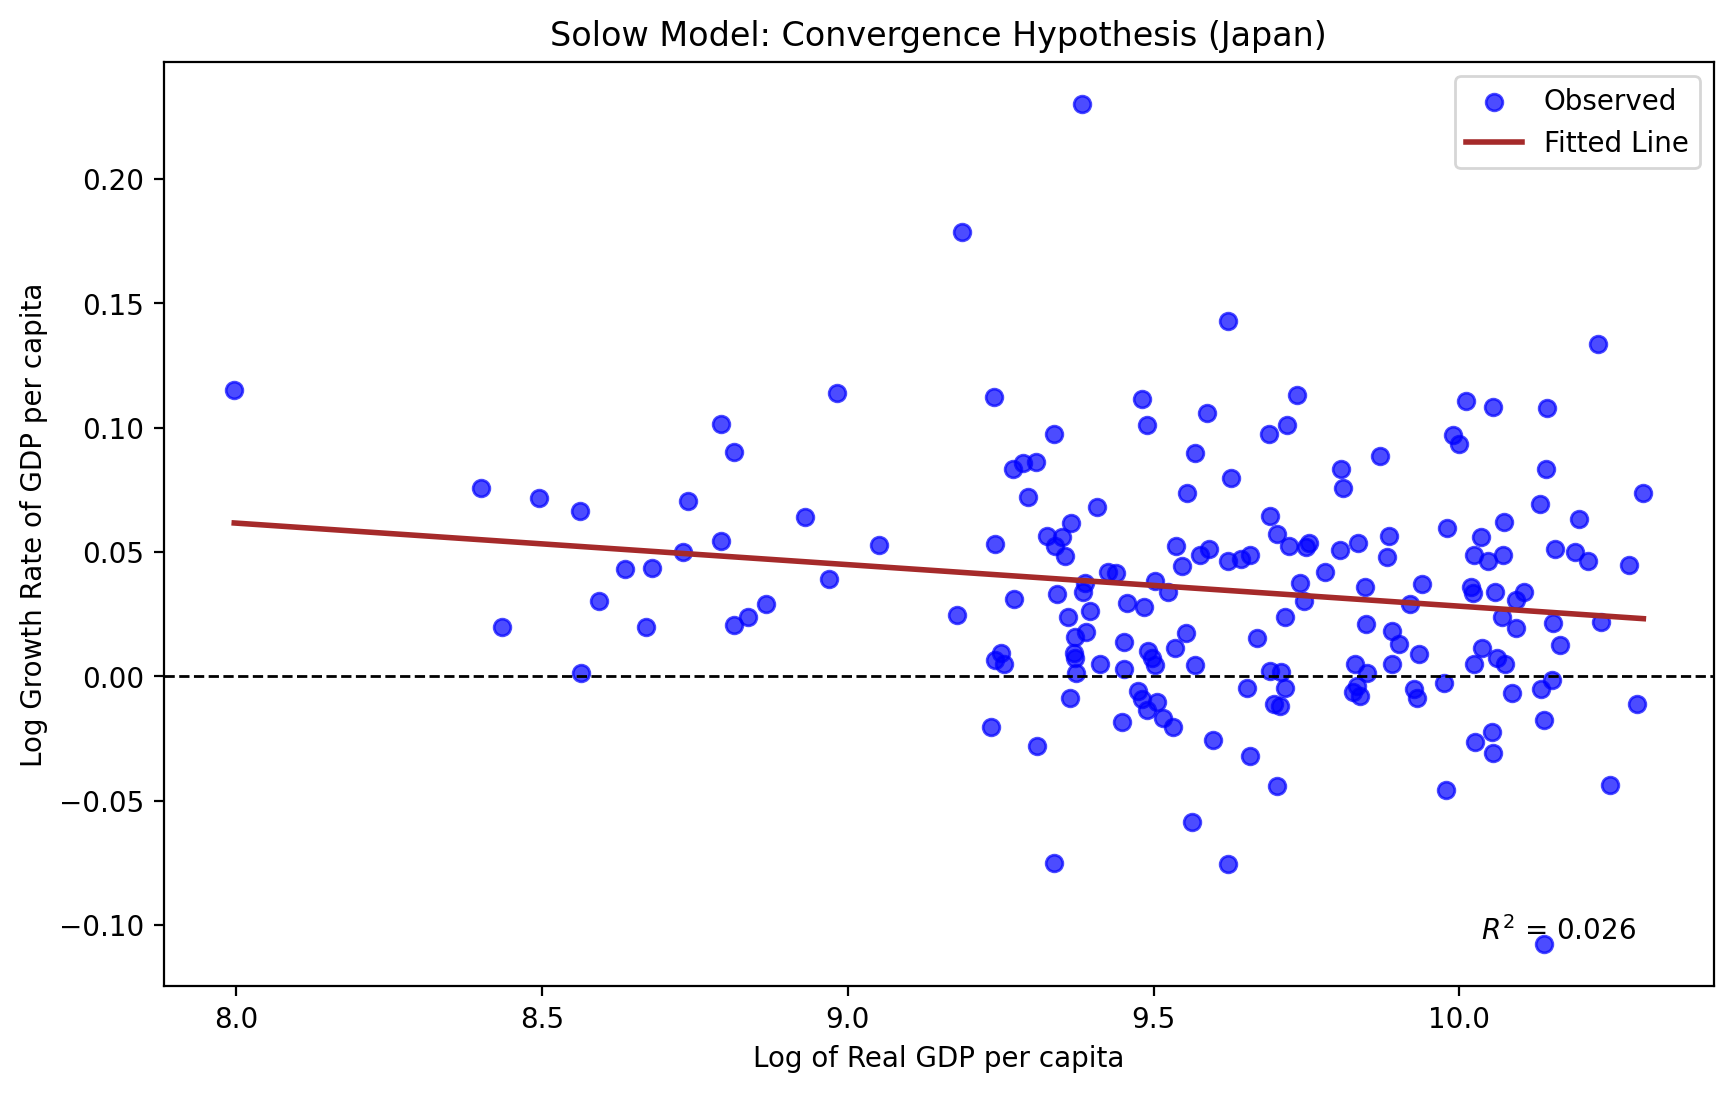

In [62]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)

data["rgdp_pc"] = data["rgdpo"] / data["pop"]

# Computing annual log growth rate
data["growth_rate"] = np.log(data["rgdp_pc"]).diff()  
data = data.dropna().reset_index(drop=True)

gdp_pc = np.log(data["rgdp_pc"]).values
growth_rate = data["growth_rate"].values

sorted_indices = np.argsort(gdp_pc)
gdp_pc_sorted = gdp_pc[sorted_indices]
growth_rate_sorted = growth_rate[sorted_indices]

# Computing regression coefficients
coeffs = get_regression_coefs(growth_rate_sorted, np.ones(len(gdp_pc_sorted)), gdp_pc_sorted)
growth_fitted = coeffs[0] + coeffs[1] * gdp_pc_sorted

# R²
r2 = calculate_r_squared(growth_rate_sorted, growth_fitted)

plt.figure(figsize=(10, 6), dpi=200)
plt.scatter(gdp_pc, growth_rate, label="Observed", color="blue", alpha=0.7)
plt.plot(gdp_pc_sorted, growth_fitted, label="Fitted Line", color="brown", linewidth=2)
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)

plt.title("Solow Model: Convergence Hypothesis (Japan)")
plt.xlabel("Log of Real GDP per capita")
plt.ylabel("Log Growth Rate of GDP per capita")
plt.legend(loc="upper right", frameon=True, fontsize=10)

# Displaying R²
text = f"$R^2$ = {r2:.3f}"
plt.text(0.95, 0.05, text, fontsize=10, ha='right', transform=plt.gca().transAxes)

plt.grid(False)
plt.show()


## Analysing Divergent paths for the real GDP and real GDP per capita over time in relative terms using indices

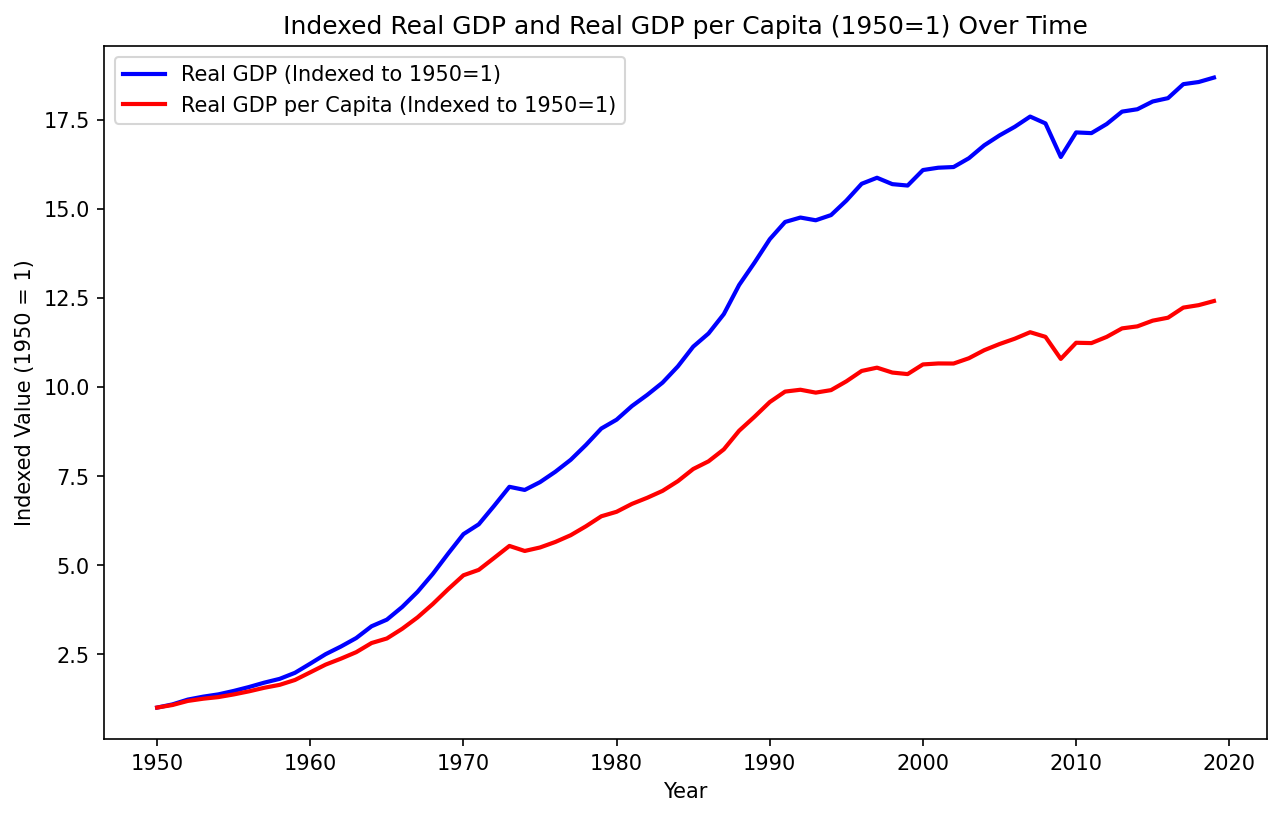

In [39]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpna", "pop"]].reset_index(drop=True)
data["rgdp_pc"] = data["rgdpna"] / data["pop"]

ymax = 2019
ymin = 1950
data = data[(data["year"] >= ymin) & (data["year"] <= ymax)].reset_index(drop=True)

# Normalising values to 1950 = 1
base_gdp = data.loc[data["year"] == 1950, "rgdpna"].values[0]
base_gdp_pc = data.loc[data["year"] == 1950, "rgdp_pc"].values[0]

data["rgdpna_indexed"] = data["rgdpna"] / base_gdp
data["rgdp_pc_indexed"] = data["rgdp_pc"] / base_gdp_pc

# Plotting indexed GDP and GDP per capita over time
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(data["year"], data["rgdpna_indexed"], label="Real GDP (Indexed to 1950=1)", linestyle="-", color="blue", linewidth=2)
plt.plot(data["year"], data["rgdp_pc_indexed"], label="Real GDP per Capita (Indexed to 1950=1)", linestyle="-", color="red", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Indexed Value (1950 = 1)")
plt.title("Indexed Real GDP and Real GDP per Capita (1950=1) Over Time")
plt.legend(frameon=True, loc="upper left")
plt.show()

## Capital Stock per Worker over time

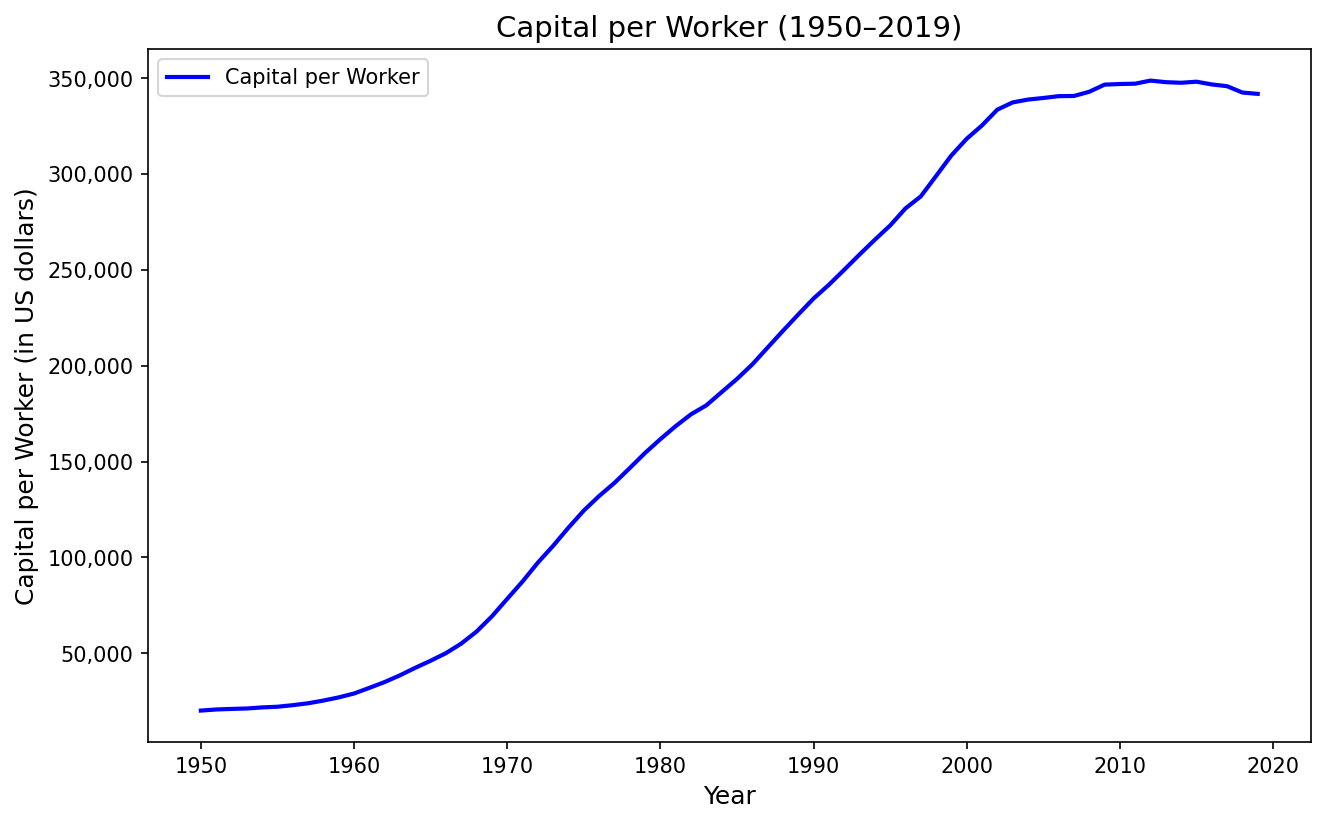

In [40]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rnna", "emp"]].reset_index(drop=True)


data.loc[data["emp"] == 0, "emp"] = np.nan 

# Computing Capital per Worker
data["Capital per Worker"] = data["rnna"] / data["emp"]

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(data["year"], data["Capital per Worker"], label="Capital per Worker", color="blue", linewidth=2)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Capital per Worker (in US dollars)", fontsize=12)
plt.title("Capital per Worker (1950–2019)", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(False)
plt.show()


## Capital Stock over time

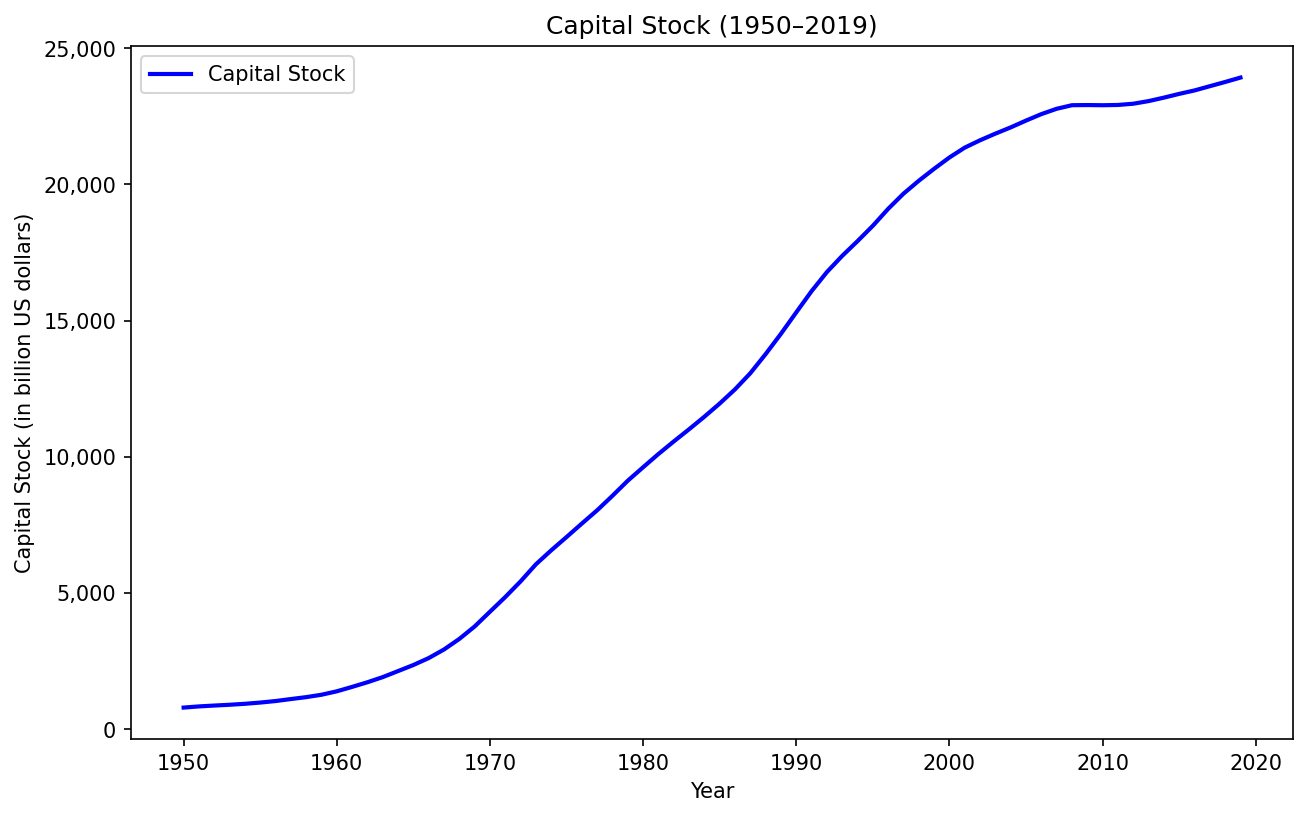

In [41]:
plt.figure(figsize=(10, 6), dpi=150)

# Converting from million to billion dollars
plt.plot(data["year"], data["rnna"] / 1e3, label="Capital Stock", color="blue", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Capital Stock (in billion US dollars)")
plt.title("Capital Stock (1950–2019)")
plt.legend()
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.grid(alpha=0.3)
plt.grid(False)
plt.show()


## Divergent paths for TFP and Labour Productivity in relative terms using indices

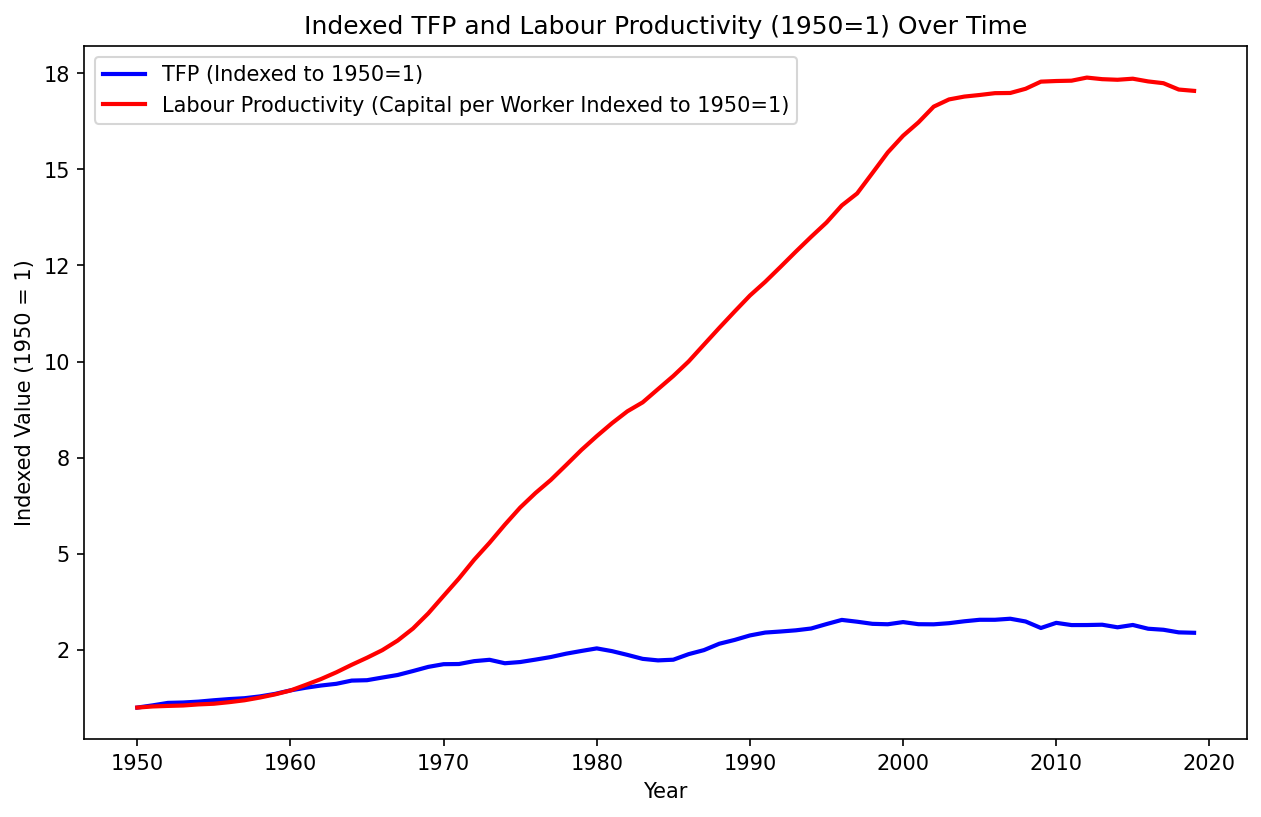

In [42]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rnna", "emp"]].reset_index(drop=True)
data.loc[data["emp"] == 0, "emp"] = np.nan 

# Computing Capital per Worker
data["Capital per Worker"] = data["rnna"] / data["emp"]

# Normalising Labour Productivity to 1950 = 1
data["labour_productivity_indexed"] = data["Capital per Worker"] / data["Capital per Worker"].iloc[0]

# Plotting Indexed TFP and Labour Productivity
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(data["year"], tfp_index, label="TFP (Indexed to 1950=1)", linestyle="-", color="blue", linewidth=2)
plt.plot(data["year"], data["labour_productivity_indexed"], label="Labour Productivity (Capital per Worker Indexed to 1950=1)", linestyle="-", color="red", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Indexed Value (1950 = 1)")
plt.title("Indexed TFP and Labour Productivity (1950=1) Over Time")
plt.legend(frameon=True, loc="upper left")

# Format y-axis to show numbers with two decimal places
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.grid(alpha=0.3)
plt.grid(False)
plt.show()

## A script to put all relevant data into one dataframe

In [55]:
data = pd.read_excel(file_path, sheet_name="Data", header=0)
data = data.loc[data["country"] == "Japan", ["year", "rgdpo", "pop", "rnna", "hc", "emp"]].reset_index(drop=True)
alpha = 0.3

# Calculating TFP
data["TFP"] = data["rgdpo"] / ((data["rnna"] ** alpha) * ((data["hc"] * data["emp"]) ** (1 - alpha)))

# Calculating Labour Productivity (Real GDP per Worker)
data["Labour Productivity"] = data["rgdpo"] / data["emp"]

# Calculating Capital Stock per Worker
data["Capital Stock per Worker"] = data["rnna"] / data["emp"]

data.rename(columns={
    "year": "Year",
    "rgdpo": "Real GDP",
    "pop": "Population",
    "rnna": "Capital Stock",
    "hc": "Human Capital Index",
    "emp": "Employment"
}, inplace=True)

# Selecting and ordering final columns
final_columns = [
    "Year", "Real GDP", "Real GDP per capita", "Population", 
    "Capital Stock", "Human Capital Index", "Employment",
    "TFP", "Labour Productivity", "Capital Stock per Worker"
]

# Computing Real GDP per capita
data["Real GDP per capita"] = data["Real GDP"] / data["Population"]

# Reordering DataFrame columns
df_final = data[final_columns]
df_final

output_file1 = "Japan_data1.xlsx"
df_final.to_excel(output_file1, index=False)